<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b><i>Copyright 2024 @ Authors</i></b><br/>
        📖 <b>Getting Started Guide</b><br/>
        Licensing Agreement: This work is licensed under the <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.<br/>
       This document can be executed directly on the <a style="font-weight:bold; color:rgb(85, 91, 228)" href="https://bohrium-doc.dp.tech/docs/userguide/Notebook" target="_blank"> Bohrium Notebook</a>. To begin, click the  <span style="background-color:rgb(85, 91, 228); color:white; padding: 3px; border-radius: 5px;box-shadow: 2px 2px 3px rgba(0, 0, 0, 0.3); font-size:0.75rem;">Connect</span>  button located at the top of the interface. We have already set up the recommended image <b><u>ubuntu:22.04-py3.10-pytorch2.0</u></b> and the recommended machine type <b><u>c2_m4_cpu</u></b> for you.
    </p>
</div>

**Uni-p*K*<sub>a</sub>** is a p*K*<sub>a</sub> prediction framework published in the article [Bridging Machine Learning and Thermodynamics for Accurate p*K*<sub>a</sub> Prediction](https://pubs.acs.org/doi/10.1021/jacsau.4c00271).

# Implementation of Uni-p*K*<sub>a</sub> model

Unfold the hidden blocks if you're interested in the implementation details, otherwise please click the "run all" button to initialize everything at your first run.

## Loading libraries



In [1]:
!pip install rdkit
!pip install matplotlib

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 18.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 21.0 MB/s eta 0:00:0000:0100:01
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 550.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 737.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 503.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 544.1 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 558.9 kB/s eta 0:00:00a 0:00:01


In [2]:
import os, sys, logging, warnings, argparse
from multiprocessing import Pool
from typing import Optional
from tqdm import tqdm
import numpy as np
from scipy.spatial import distance_matrix
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDLogger
import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

RDLogger.DisableLog('rdApp.*') 
warnings.filterwarnings(action='ignore')
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=os.environ.get("LOGLEVEL", "INFO").upper(),
    stream=sys.stdout,
)
logger = logging.getLogger("unimol_free_energy.inference")
logging.disable(50)

## Dictionary class

In [3]:
class Dictionary:
    """A mapping from symbols to consecutive integers"""

    def __init__(
        self,
        *,  # begin keyword-only arguments
        bos="[CLS]",
        pad="[PAD]",
        eos="[SEP]",
        unk="[UNK]",
        extra_special_symbols=None,
    ):
        self.bos_word, self.unk_word, self.pad_word, self.eos_word = bos, unk, pad, eos
        self.symbols = []
        self.count = []
        self.indices = {}
        self.specials = set()
        self.specials.add(bos)
        self.specials.add(unk)
        self.specials.add(pad)
        self.specials.add(eos)

    def __eq__(self, other):
        return self.indices == other.indices

    def __getitem__(self, idx):
        if idx < len(self.symbols):
            return self.symbols[idx]
        return self.unk_word

    def __len__(self):
        """Returns the number of symbols in the dictionary"""
        return len(self.symbols)

    def __contains__(self, sym):
        return sym in self.indices

    def vec_index(self, a):
        return np.vectorize(self.index)(a)

    def index(self, sym):
        """Returns the index of the specified symbol"""
        assert isinstance(sym, str)
        if sym in self.indices:
            return self.indices[sym]
        return self.indices[self.unk_word]
    
    def special_index(self):
        return [self.index(x) for x in self.specials]

    def add_symbol(self, word, n=1, overwrite=False, is_special=False):
        """Adds a word to the dictionary"""
        if is_special:
            self.specials.add(word)
        if word in self.indices and not overwrite:
            idx = self.indices[word]
            self.count[idx] = self.count[idx] + n
            return idx
        else:
            idx = len(self.symbols)
            self.indices[word] = idx
            self.symbols.append(word)
            self.count.append(n)
            return idx

    def bos(self):
        """Helper to get index of beginning-of-sentence symbol"""
        return self.index(self.bos_word)

    def pad(self):
        """Helper to get index of pad symbol"""
        return self.index(self.pad_word)

    def eos(self):
        """Helper to get index of end-of-sentence symbol"""
        return self.index(self.eos_word)

    def unk(self):
        """Helper to get index of unk symbol"""
        return self.index(self.unk_word)

    @classmethod
    def load(cls, f):
        """Loads the dictionary from a text file with the format:

        ```
        <symbol0> <count0>
        <symbol1> <count1>
        ...
        ```
        """
        d = cls()
        d.add_from_file(f)
        return d

    @classmethod
    def load_from_str(cls, s):
        d = cls()
        d.add_from_lines(s.split("\n"))
        return d

    def add_from_lines(self, lines):
        for line_idx, line in enumerate(lines):
            try:
                splits = line.rstrip().rsplit(" ", 1)
                line = splits[0]
                field = splits[1] if len(splits) > 1 else str(len(lines) - line_idx)
                if field == "#overwrite":
                    overwrite = True
                    line, field = line.rsplit(" ", 1)
                else:
                    overwrite = False
                count = int(field)
                word = line
                if word in self and not overwrite:
                    logger.info(
                        "Duplicate word found when loading Dictionary: '{}', index is {}.".format(word, self.indices[word])
                    )
                else:
                    self.add_symbol(word, n=count, overwrite=overwrite)
            except ValueError:
                raise ValueError(
                    "Incorrect dictionary format, expected '<token> <cnt> [flags]'"
                )


    def add_from_file(self, f):
        """
        Loads a pre-existing dictionary from a text file and adds its symbols
        to this instance.
        """
        if isinstance(f, str):
            try:
                with open(f, "r", encoding="utf-8") as fd:
                    self.add_from_file(fd)
            except FileNotFoundError as fnfe:
                raise fnfe
            except UnicodeError:
                raise Exception(
                    "Incorrect encoding detected in {}, please "
                    "rebuild the dataset".format(f)
                )
            return

        lines = f.readlines()
        self.add_from_lines(lines)
        

## Atom type and charge dictionary

In [4]:
DICT = '''[PAD]
[CLS]
[SEP]
[UNK]
C
N
O
S
H
Cl
F
Br
I
Si
P
B
Na
K
Al
Ca
Sn
As
Hg
Fe
Zn
Cr
Se
Gd
Au
Li'''
DICT_CHARGE = '''[PAD]
[CLS]
[SEP]
[UNK]
1
0
-1'''

## 3D conformational generation

In [5]:
class ConformerGen(object):
    '''
    This class designed to generate conformers for molecules represented as SMILES strings using provided parameters and configurations. The `transform` method uses multiprocessing to speed up the conformer generation process.
    '''
    def __init__(self, **params):
        """
        Initializes the neural network model based on the provided model name and parameters.

        :param model_name: (str) The name of the model to initialize.
        :param params: Additional parameters for model configuration.

        :return: An instance of the specified neural network model.
        :raises ValueError: If the model name is not recognized.
        """
        self._init_features(**params)

    def _init_features(self, **params):
        """
        Initializes the features of the ConformerGen object based on provided parameters.

        :param params: Arbitrary keyword arguments for feature configuration.
                       These can include the random seed, maximum number of atoms, data type,
                       generation method, generation mode, and whether to remove hydrogens.
        """
        self.seed = params.get('seed', 42)
        self.max_atoms = params.get('max_atoms', 256)
        self.data_type = params.get('data_type', 'molecule')
        self.method = params.get('method', 'rdkit_random')
        self.mode = params.get('mode', 'fast')
        self.remove_hs = params.get('remove_hs', False)
        self.dict_dir = params.get('dict_dir', 'dict')
        self.dictionary = Dictionary.load_from_str(DICT)
        self.dictionary.add_symbol("[MASK]", is_special=True)
        self.charge_dictionary = Dictionary.load_from_str(DICT_CHARGE)
        self.charge_dictionary.add_symbol("[MASK]", is_special=True)

    def single_process(self, smiles):
        """
        Processes a single SMILES string to generate conformers using the specified method.

        :param smiles: (str) The SMILES string representing the molecule.
        :return: A unimolecular data representation (dictionary) of the molecule.
        :raises ValueError: If the conformer generation method is unrecognized.
        """
        if self.method == 'rdkit_random':
            atoms, coordinates, charges = inner_smi2coords(smiles, seed=self.seed, mode=self.mode, remove_hs=self.remove_hs)
            return coords2unimol(atoms, coordinates, charges, self.dictionary, self.charge_dictionary, self.max_atoms, remove_hs=self.remove_hs)
        else:
            raise ValueError('Unknown conformer generation method: {}'.format(self.method))
        
    def transform_raw(self, atoms_list, coordinates_list, charges_list):

        inputs = []
        for atoms, coordinates, charges in zip(atoms_list, coordinates_list, charges_list):
            inputs.append(coords2unimol(atoms, coordinates, charges, self.dictionary, self.charge_dictionary, self.max_atoms, remove_hs=self.remove_hs))
        return inputs

    def transform(self, smiles_list):
        logger.info('Start generating conformers...')
        inputs = [self.single_process(item) for item in smiles_list]
        failed_cnt = np.mean([(item['src_coord']==0.0).all() for item in inputs])
        logger.info('Succeed to generate conformers for {:.2f}% of molecules.'.format((1-failed_cnt)*100))
        failed_3d_cnt = np.mean([(item['src_coord'][:,2]==0.0).all() for item in inputs])
        logger.info('Succeed to generate 3d conformers for {:.2f}% of molecules.'.format((1-failed_3d_cnt)*100))
        return inputs


def inner_smi2coords(smi, seed=42, mode='fast', remove_hs=True):
    '''
    This function is responsible for converting a SMILES (Simplified Molecular Input Line Entry System) string into 3D coordinates for each atom in the molecule. It also allows for the generation of 2D coordinates if 3D conformation generation fails, and optionally removes hydrogen atoms and their coordinates from the resulting data.

    :param smi: (str) The SMILES representation of the molecule.
    :param seed: (int, optional) The random seed for conformation generation. Defaults to 42.
    :param mode: (str, optional) The mode of conformation generation, 'fast' for quick generation, 'heavy' for more attempts. Defaults to 'fast'.
    :param remove_hs: (bool, optional) Whether to remove hydrogen atoms from the final coordinates. Defaults to True.

    :return: A tuple containing the list of atom symbols and their corresponding 3D coordinates.
    :raises AssertionError: If no atoms are present in the molecule or if the coordinates do not align with the atom count.
    '''
    mol = Chem.MolFromSmiles(smi)
    mol = AllChem.AddHs(mol)
    atoms, charges = [], []
    for atom in mol.GetAtoms():
        atoms.append(atom.GetSymbol())
        charges.append(atom.GetFormalCharge())
    assert len(atoms)>0, 'No atoms in molecule: {}'.format(smi)
    try:
        # will random generate conformer with seed equal to -1. else fixed random seed.
        res = AllChem.EmbedMolecule(mol, randomSeed=seed)
        if res == 0:
            try:
                # some conformer can not use MMFF optimize
                AllChem.MMFFOptimizeMolecule(mol)
                coordinates = mol.GetConformer().GetPositions().astype(np.float32)
            except:
                coordinates = mol.GetConformer().GetPositions().astype(np.float32)
        ## for fast test... ignore this ###
        elif res == -1 and mode == 'heavy':
            AllChem.EmbedMolecule(mol, maxAttempts=5000, randomSeed=seed)
            try:
                # some conformer can not use MMFF optimize
                AllChem.MMFFOptimizeMolecule(mol)
                coordinates = mol.GetConformer().GetPositions().astype(np.float32)
            except:
                AllChem.Compute2DCoords(mol)
                coordinates_2d = mol.GetConformer().GetPositions().astype(np.float32)
                coordinates = coordinates_2d
        else:
            AllChem.Compute2DCoords(mol)
            coordinates_2d = mol.GetConformer().GetPositions().astype(np.float32)
            coordinates = coordinates_2d
    except:
        print("Failed to generate conformer, replace with zeros.")
        coordinates = np.zeros((len(atoms),3))
    assert len(atoms) == len(coordinates), "coordinates shape is not align with {}".format(smi)
    if remove_hs:
        idx = [i for i, atom in enumerate(atoms) if atom != 'H']
        atoms_no_h = [atom for atom in atoms if atom != 'H']
        coordinates_no_h = coordinates[idx]
        charges_no_h = [charges[i] for i in idx]
        assert len(atoms_no_h) == len(coordinates_no_h), "coordinates shape is not align with {}".format(smi)
        return atoms_no_h, coordinates_no_h, charges_no_h
    else:
        return atoms, coordinates, charges

def inner_coords(atoms, coordinates, charges, remove_hs=True):
    """
    Processes a list of atoms and their corresponding coordinates to remove hydrogen atoms if specified.
    This function takes a list of atom symbols and their corresponding coordinates and optionally removes hydrogen atoms from the output. It includes assertions to ensure the integrity of the data and uses numpy for efficient processing of the coordinates. 

    :param atoms: (list) A list of atom symbols (e.g., ['C', 'H', 'O']).
    :param coordinates: (list of tuples or list of lists) Coordinates corresponding to each atom in the `atoms` list.
    :param remove_hs: (bool, optional) A flag to indicate whether hydrogen atoms should be removed from the output.
                      Defaults to True.
    
    :return: A tuple containing two elements; the filtered list of atom symbols and their corresponding coordinates.
             If `remove_hs` is False, the original lists are returned.
    
    :raises AssertionError: If the length of `atoms` list does not match the length of `coordinates` list.
    """
    assert len(atoms) == len(coordinates), "coordinates shape is not align atoms"
    coordinates = np.array(coordinates).astype(np.float32)
    if remove_hs:
        idx = [i for i, atom in enumerate(atoms) if atom != 'H']
        atoms_no_h = [atom for atom in atoms if atom != 'H']
        coordinates_no_h = coordinates[idx]
        charges_no_h = [charges[i] for i in idx]
        assert len(atoms_no_h) == len(coordinates_no_h), "coordinates shape is not align with atoms"
        return atoms_no_h, coordinates_no_h, charges_no_h
    else:
        return atoms, coordinates, charges

def coords2unimol(atoms, coordinates, charges, dictionary, charge_dictionary, max_atoms=256, remove_hs=True, **params):
    """
    Converts atom symbols and coordinates into a unified molecular representation.

    :param atoms: (list) List of atom symbols.
    :param coordinates: (ndarray) Array of atomic coordinates.
    :param dictionary: (Dictionary) An object that maps atom symbols to unique integers.
    :param max_atoms: (int) The maximum number of atoms to consider for the molecule.
    :param remove_hs: (bool) Whether to remove hydrogen atoms from the representation.
    :param params: Additional parameters.

    :return: A dictionary containing the molecular representation with tokens, distances, coordinates, and edge types.
    """
    atoms, coordinates, charges = inner_coords(atoms, coordinates, charges, remove_hs=remove_hs)
    atoms = np.array(atoms)
    coordinates = np.array(coordinates).astype(np.float32)
    charges = np.array(charges).astype(str)
    # cropping atoms and coordinates
    if len(atoms) > max_atoms:
        idx = np.random.choice(len(atoms), max_atoms, replace=False)
        atoms = atoms[idx]
        coordinates = coordinates[idx]
        charges = charges[idx]
    # tokens padding
    src_tokens = np.array([dictionary.bos()] + [dictionary.index(atom) for atom in atoms] + [dictionary.eos()])
    src_distance = np.zeros((len(src_tokens), len(src_tokens)))
    src_charges = np.array([charge_dictionary.bos()] + [charge_dictionary.index(charge) for charge in charges] + [charge_dictionary.eos()])
    # coordinates normalize & padding
    src_coord = coordinates - coordinates.mean(axis=0)
    src_coord = np.concatenate([np.zeros((1,3)), src_coord, np.zeros((1,3))], axis=0)
    # distance matrix
    src_distance = distance_matrix(src_coord, src_coord)
    # edge type
    src_edge_type = src_tokens.reshape(-1, 1) * len(dictionary) + src_tokens.reshape(1, -1)

    return {
            'src_tokens': src_tokens.astype(int), 
            'src_charges': src_charges.astype(int),
            'src_distance': src_distance.astype(np.float32), 
            'src_coord': src_coord.astype(np.float32), 
            'src_edge_type': src_edge_type.astype(int),
            }

## Transformer backbone

In [6]:

def softmax_dropout(input, dropout_prob, is_training=True, mask=None, bias=None, inplace=True):
    """softmax dropout, and mask, bias are optional.
    Args:
        input (torch.Tensor): input tensor
        dropout_prob (float): dropout probability
        is_training (bool, optional): is in training or not. Defaults to True.
        mask (torch.Tensor, optional): the mask tensor, use as input + mask . Defaults to None.
        bias (torch.Tensor, optional): the bias tensor, use as input + bias . Defaults to None.

    Returns:
        torch.Tensor: the result after softmax
    """
    input = input.contiguous()
    if not inplace:
        # copy a input for non-inplace case
        input = input.clone()
    if mask is not None:
        input += mask
    if bias is not None:
        input += bias
    return F.dropout(F.softmax(input, dim=-1), p=dropout_prob, training=is_training)

def get_activation_fn(activation):
    """ Returns the activation function corresponding to `activation` """

    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu
    elif activation == "tanh":
        return torch.tanh
    elif activation == "linear":
        return lambda x: x
    else:
        raise RuntimeError("--activation-fn {} not supported".format(activation))

class SelfMultiheadAttention(nn.Module):
    def __init__(
        self,
        embed_dim,
        num_heads,
        dropout=0.1,
        bias=True,
        scaling_factor=1,
    ):
        super().__init__()
        self.embed_dim = embed_dim

        self.num_heads = num_heads
        self.dropout = dropout

        self.head_dim = embed_dim // num_heads
        assert (
            self.head_dim * num_heads == self.embed_dim
        ), "embed_dim must be divisible by num_heads"
        self.scaling = (self.head_dim * scaling_factor) ** -0.5

        self.in_proj = nn.Linear(embed_dim, embed_dim * 3, bias=bias)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

    def forward(
        self,
        query,
        key_padding_mask: Optional[Tensor] = None,
        attn_bias: Optional[Tensor] = None,
        return_attn: bool = False,
    ) -> Tensor:

        bsz, tgt_len, embed_dim = query.size()
        assert embed_dim == self.embed_dim

        q, k, v = self.in_proj(query).chunk(3, dim=-1)

        q = (
            q.view(bsz, tgt_len, self.num_heads, self.head_dim)
            .transpose(1, 2)
            .contiguous()
            .view(bsz * self.num_heads, -1, self.head_dim)
            * self.scaling
        )
        if k is not None:
            k = (
                k.view(bsz, -1, self.num_heads, self.head_dim)
                .transpose(1, 2)
                .contiguous()
                .view(bsz * self.num_heads, -1, self.head_dim)
            )
        if v is not None:
            v = (
                v.view(bsz, -1, self.num_heads, self.head_dim)
                .transpose(1, 2)
                .contiguous()
                .view(bsz * self.num_heads, -1, self.head_dim)
            )

        assert k is not None
        src_len = k.size(1)

        # This is part of a workaround to get around fork/join parallelism
        # not supporting Optional types.
        if key_padding_mask is not None and key_padding_mask.dim() == 0:
            key_padding_mask = None

        if key_padding_mask is not None:
            assert key_padding_mask.size(0) == bsz
            assert key_padding_mask.size(1) == src_len

        attn_weights = torch.bmm(q, k.transpose(1, 2))

        assert list(attn_weights.size()) == [bsz * self.num_heads, tgt_len, src_len]

        if key_padding_mask is not None:
            # don't attend to padding symbols
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights.masked_fill_(
                key_padding_mask.unsqueeze(1).unsqueeze(2).to(torch.bool), float("-inf")
            )
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        if not return_attn:
            attn = softmax_dropout(
                attn_weights, self.dropout, self.training, bias=attn_bias,
            )
        else:
            attn_weights += attn_bias
            attn = softmax_dropout(
                attn_weights, self.dropout, self.training, inplace=False,
            )

        o = torch.bmm(attn, v)
        assert list(o.size()) == [bsz * self.num_heads, tgt_len, self.head_dim]

        o = (
            o.view(bsz, self.num_heads, tgt_len, self.head_dim)
            .transpose(1, 2)
            .contiguous()
            .view(bsz, tgt_len, embed_dim)
        )
        o = self.out_proj(o)
        if not return_attn:
            return o
        else:
            return o, attn_weights, attn

class TransformerEncoderLayer(nn.Module):
    """
    Implements a Transformer Encoder Layer used in BERT/XLM style pre-trained
    models.
    """

    def __init__(
        self,
        embed_dim: int = 768,
        ffn_embed_dim: int = 3072,
        attention_heads: int = 8,
        dropout: float = 0.1,
        attention_dropout: float = 0.1,
        activation_dropout: float = 0.0,
        activation_fn: str = "gelu",
        post_ln = False,
    ) -> None:
        super().__init__()

        # Initialize parameters
        self.embed_dim = embed_dim
        self.attention_heads = attention_heads
        self.attention_dropout = attention_dropout

        self.dropout = dropout
        self.activation_dropout = activation_dropout
        self.activation_fn = get_activation_fn(activation_fn)

        self.self_attn = SelfMultiheadAttention(
            self.embed_dim,
            attention_heads,
            dropout=attention_dropout,
        )
        # layer norm associated with the self attention layer
        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.fc1 = nn.Linear(self.embed_dim, ffn_embed_dim)
        self.fc2 = nn.Linear(ffn_embed_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)
        self.post_ln = post_ln


    def forward(
        self,
        x: torch.Tensor,
        attn_bias: Optional[torch.Tensor] = None,
        padding_mask: Optional[torch.Tensor] = None,
        return_attn: bool=False,
    ) -> torch.Tensor:
        """
        LayerNorm is applied either before or after the self-attention/ffn
        modules similar to the original Transformer implementation.
        """
        residual = x
        if not self.post_ln:
            x = self.self_attn_layer_norm(x)
        # new added
        x = self.self_attn(
            query=x,
            key_padding_mask=padding_mask,
            attn_bias=attn_bias,
            return_attn=return_attn,
        )
        if return_attn:
            x, attn_weights, attn_probs = x
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = residual + x
        if self.post_ln:
            x = self.self_attn_layer_norm(x)

        residual = x
        if not self.post_ln:
            x = self.final_layer_norm(x)
        x = self.fc1(x)
        x = self.activation_fn(x)
        x = F.dropout(x, p=self.activation_dropout, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = residual + x
        if self.post_ln:
            x = self.final_layer_norm(x)
        if not return_attn:
            return x
        else:
            return x, attn_weights, attn_probs

class TransformerEncoderWithPair(nn.Module):
    """
    A custom Transformer Encoder module that extends PyTorch's nn.Module. This encoder is designed for tasks that require understanding pair relationships in sequences. It includes standard transformer encoder layers along with additional normalization and dropout features.

    Attributes:
        - emb_dropout: Dropout rate applied to the embedding layer.
        - max_seq_len: Maximum length of the input sequences.
        - embed_dim: Dimensionality of the embeddings.
        - attention_heads: Number of attention heads in the transformer layers.
        - emb_layer_norm: Layer normalization applied to the embedding layer.
        - final_layer_norm: Optional final layer normalization.
        - final_head_layer_norm: Optional layer normalization for the attention heads.
        - layers: A list of transformer encoder layers.

    Methods:
        forward: Performs the forward pass of the module.
    """
    
    def __init__(
        self,
        encoder_layers: int = 6,
        embed_dim: int = 768,
        ffn_embed_dim: int = 3072,
        attention_heads: int = 8,
        emb_dropout: float = 0.1,
        dropout: float = 0.1,
        attention_dropout: float = 0.1,
        activation_dropout: float = 0.0,
        max_seq_len: int = 256,
        activation_fn: str = "gelu",
        post_ln: bool = False,
        no_final_head_layer_norm: bool = False,
    ) -> None:
        """
        Initializes and configures the layers and other components of the transformer encoder.
        
        :param encoder_layers: (int) Number of encoder layers in the transformer.
        :param embed_dim: (int) Dimensionality of the input embeddings.
        :param ffn_embed_dim: (int) Dimensionality of the feedforward network model.
        :param attention_heads: (int) Number of attention heads in each encoder layer.
        :param emb_dropout: (float) Dropout rate for the embedding layer.
        :param dropout: (float) Dropout rate for the encoder layers.
        :param attention_dropout: (float) Dropout rate for the attention mechanisms.
        :param activation_dropout: (float) Dropout rate for activations.
        :param max_seq_len: (int) Maximum sequence length the model can handle.
        :param activation_fn: (str) The activation function to use (e.g., "gelu").
        :param post_ln: (bool) If True, applies layer normalization after the feedforward network.
        :param no_final_head_layer_norm: (bool) If True, does not apply layer normalization to the final attention head.

        """
        super().__init__()
        self.emb_dropout = emb_dropout
        self.max_seq_len = max_seq_len
        self.embed_dim = embed_dim
        self.attention_heads = attention_heads
        self.emb_layer_norm = nn.LayerNorm(self.embed_dim)
        if not post_ln:
            self.final_layer_norm = nn.LayerNorm(self.embed_dim)
        else:
            self.final_layer_norm = None

        if not no_final_head_layer_norm:
            self.final_head_layer_norm = nn.LayerNorm(attention_heads)
        else:
            self.final_head_layer_norm = None

        self.layers = nn.ModuleList(
            [
                TransformerEncoderLayer(
                    embed_dim=self.embed_dim,
                    ffn_embed_dim=ffn_embed_dim,
                    attention_heads=attention_heads,
                    dropout=dropout,
                    attention_dropout=attention_dropout,
                    activation_dropout=activation_dropout,
                    activation_fn=activation_fn,
                    post_ln=post_ln,
                )
                for _ in range(encoder_layers)
            ]
        )

    def forward(
        self,
        emb: torch.Tensor,
        attn_mask: Optional[torch.Tensor] = None,
        padding_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        """
        Conducts the forward pass of the transformer encoder.

        :param emb: (torch.Tensor) The input tensor of embeddings.
        :param attn_mask: (Optional[torch.Tensor]) Attention mask to specify positions to attend to.
        :param padding_mask: (Optional[torch.Tensor]) Mask to indicate padded elements in the input.

        :return: (torch.Tensor) The output tensor after passing through the transformer encoder layers.
                 It also returns tensors related to pair representation and normalization losses.
        """
        bsz = emb.size(0)
        seq_len = emb.size(1)
        x = self.emb_layer_norm(emb)
        x = F.dropout(x, p=self.emb_dropout, training=self.training)
        # account for padding while computing the representation
        if padding_mask is not None:
            x = x * (1 - padding_mask.unsqueeze(-1).type_as(x))
        input_attn_mask = attn_mask
        input_padding_mask = padding_mask

        def fill_attn_mask(attn_mask, padding_mask, fill_val=float("-inf")):
            if attn_mask is not None and padding_mask is not None:
                # merge key_padding_mask and attn_mask
                attn_mask = attn_mask.view(x.size(0), -1, seq_len, seq_len)
                attn_mask.masked_fill_(
                    padding_mask.unsqueeze(1).unsqueeze(2).to(torch.bool),
                    fill_val,
                )
                attn_mask = attn_mask.view(-1, seq_len, seq_len)
                padding_mask = None
            return attn_mask, padding_mask

        assert attn_mask is not None
        attn_mask, padding_mask = fill_attn_mask(attn_mask, padding_mask)
        for i in range(len(self.layers)):
            x, attn_mask, _ = self.layers[i](
                x, padding_mask=padding_mask, attn_bias=attn_mask, return_attn=True
            )

        def norm_loss(x, eps=1e-10, tolerance=1.0):
            x = x.float()
            max_norm = x.shape[-1] ** 0.5
            norm = torch.sqrt(torch.sum(x**2, dim=-1) + eps)
            error = torch.nn.functional.relu((norm - max_norm).abs() - tolerance)
            return error

        def masked_mean(mask, value, dim=-1, eps=1e-10):
            return (
                torch.sum(mask * value, dim=dim) / (eps + torch.sum(mask, dim=dim))
            ).mean()

        x_norm = norm_loss(x)
        if input_padding_mask is not None:
            token_mask = 1.0 - input_padding_mask.float()
        else:
            token_mask = torch.ones_like(x_norm, device=x_norm.device)
        x_norm = masked_mean(token_mask, x_norm)

        if self.final_layer_norm is not None:
            x = self.final_layer_norm(x)

        delta_pair_repr = attn_mask - input_attn_mask
        delta_pair_repr, _ = fill_attn_mask(delta_pair_repr, input_padding_mask, 0)
        attn_mask = (
            attn_mask.view(bsz, -1, seq_len, seq_len).permute(0, 2, 3, 1).contiguous()
        )
        delta_pair_repr = (
            delta_pair_repr.view(bsz, -1, seq_len, seq_len)
            .permute(0, 2, 3, 1)
            .contiguous()
        )

        pair_mask = token_mask[..., None] * token_mask[..., None, :]
        delta_pair_repr_norm = norm_loss(delta_pair_repr)
        delta_pair_repr_norm = masked_mean(
            pair_mask, delta_pair_repr_norm, dim=(-1, -2)
        )

        if self.final_head_layer_norm is not None:
            delta_pair_repr = self.final_head_layer_norm(delta_pair_repr)

        return x, attn_mask, delta_pair_repr, x_norm, delta_pair_repr_norm


## Uni-Mol model

In [7]:
BACKBONE = {
    'transformer': TransformerEncoderWithPair,
}

class UniMolModel(nn.Module):
    """
    UniMolModel is a specialized model for molecular, protein, crystal, or MOF (Metal-Organic Frameworks) data. 
    It dynamically configures its architecture based on the type of data it is intended to work with. The model
    supports multiple data types and incorporates various architecture configurations and pretrained weights.

    Attributes:
        - output_dim: The dimension of the output layer.
        - data_type: The type of data the model is designed to handle.
        - remove_hs: Flag to indicate whether hydrogen atoms are removed in molecular data.
        - pretrain_path: Path to the pretrained model weights.
        - dictionary: The dictionary object used for tokenization and encoding.
        - mask_idx: Index of the mask token in the dictionary.
        - padding_idx: Index of the padding token in the dictionary.
        - embed_tokens: Embedding layer for token embeddings.
        - encoder: Transformer encoder backbone of the model.
        - gbf_proj, gbf: Layers for Gaussian basis functions or numerical embeddings.
        - classification_head: The final classification head of the model.
    """
    def __init__(self, model_path, output_dim=2, **params):
        """
        Initializes the UniMolModel with specified parameters and data type.

        :param output_dim: (int) The number of output dimensions (classes).
        :param data_type: (str) The type of data (e.g., 'molecule', 'protein').
        :param params: Additional parameters for model configuration.
        """
        super().__init__()
        self.args = molecule_architecture()
        self.output_dim = output_dim
        self.remove_hs = params.get('remove_hs', False)
        self.pretrain_path = model_path
        self.head_name = params.get('head_name', 'chembl_all')
        self.dict_dir = params.get('dict_dir', 'dict')
        self.dictionary = Dictionary.load_from_str(DICT)
        self.mask_idx = self.dictionary.add_symbol("[MASK]", is_special=True)
        self.padding_idx = self.dictionary.pad()
        self.embed_tokens = nn.Embedding(
            len(self.dictionary), self.args.encoder_embed_dim, self.padding_idx
        )
        self.charge_dictionary = Dictionary.load_from_str(DICT_CHARGE)
        self.charge_mask_idx = self.charge_dictionary.add_symbol("[MASK]", is_special=True)
        self.charge_padding_idx = self.charge_dictionary.pad()
        self.embed_charges = nn.Embedding(
            len(self.charge_dictionary), self.args.encoder_embed_dim, self.charge_padding_idx
        )
        self.encoder = BACKBONE[self.args.backbone](
            encoder_layers=self.args.encoder_layers,
            embed_dim=self.args.encoder_embed_dim,
            ffn_embed_dim=self.args.encoder_ffn_embed_dim,
            attention_heads=self.args.encoder_attention_heads,
            emb_dropout=self.args.emb_dropout,
            dropout=self.args.dropout,
            attention_dropout=self.args.attention_dropout,
            activation_dropout=self.args.activation_dropout,
            max_seq_len=self.args.max_seq_len,
            activation_fn=self.args.activation_fn,
            no_final_head_layer_norm=self.args.delta_pair_repr_norm_loss < 0,
        )
        K = 128
        n_edge_type = len(self.dictionary) * len(self.dictionary)
        self.gbf_proj = NonLinearHead(
            K, self.args.encoder_attention_heads, self.args.activation_fn
        )
        if self.args.kernel == 'gaussian':
            self.gbf = GaussianLayer(K, n_edge_type)
        self.classification_heads = nn.ModuleDict()
        self.classification_heads[self.head_name] = ClassificationHead(
            input_dim=self.args.encoder_embed_dim,
            inner_dim=self.args.encoder_embed_dim,
            num_classes=self.output_dim,
            activation_fn=self.args.pooler_activation_fn,
            pooler_dropout=self.args.pooler_dropout,
        )
        self.load_pretrained_weights(path=self.pretrain_path)

    def load_pretrained_weights(self, path):
        """
        Loads pretrained weights into the model.

        :param path: (str) Path to the pretrained weight file.
        """
        if path is not None:
            logger.info("Loading pretrained weights from {}".format(path))
            state_dict = torch.load(path, map_location=lambda storage, loc: storage)
            errors = self.load_state_dict(state_dict['model'], strict=True)
            if errors.missing_keys:
                logger.warning(
                    "Error in loading model state, missing_keys "
                    + str(errors.missing_keys)
                )
            if errors.unexpected_keys:
                logger.warning(
                    "Error in loading model state, unexpected_keys "
                    + str(errors.unexpected_keys)
                )

    @classmethod
    def build_model(cls, args):
        """
        Class method to build a new instance of the UniMolModel.

        :param args: Arguments for model configuration.
        :return: An instance of UniMolModel.
        """
        return cls(args)

    def forward(
        self,
        src_tokens,
        src_charges,
        src_distance,
        src_coord,
        src_edge_type,
        return_repr=False,
        return_atomic_reprs=False,
        **kwargs
    ):
        """
        Defines the forward pass of the model.

        :param src_tokens: Tokenized input data.
        :param src_distance: Additional molecular features.
        :param src_coord: Additional molecular features.
        :param src_edge_type: Additional molecular features.
        :param gas_id: Optional environmental features for MOFs.
        :param gas_attr: Optional environmental features for MOFs.
        :param pressure: Optional environmental features for MOFs.
        :param temperature: Optional environmental features for MOFs.
        :param return_repr: Flags to return intermediate representations.
        :param return_atomic_reprs: Flags to return intermediate representations.

        :return: Output logits or requested intermediate representations.
        """
        padding_mask = src_tokens.eq(self.padding_idx)
        if not padding_mask.any():
            padding_mask = None
        x = self.embed_tokens(src_tokens)
        # involve charge info
        charge_padding_mask = src_charges.eq(self.charge_padding_idx)
        if not charge_padding_mask.any():
            padding_mask = None
        charges_emb = self.embed_charges(src_charges)
        x += charges_emb

        def get_dist_features(dist, et):
            n_node = dist.size(-1)
            gbf_feature = self.gbf(dist, et)
            gbf_result = self.gbf_proj(gbf_feature)
            graph_attn_bias = gbf_result
            graph_attn_bias = graph_attn_bias.permute(0, 3, 1, 2).contiguous()
            graph_attn_bias = graph_attn_bias.view(-1, n_node, n_node)
            return graph_attn_bias
        graph_attn_bias = get_dist_features(src_distance, src_edge_type)
        (
            encoder_rep,
            _,
            _,
            _,
            _,
        ) = self.encoder(x, padding_mask=padding_mask, attn_mask=graph_attn_bias)
        cls_repr = encoder_rep[:, 0, :]  # CLS token repr
        all_repr = encoder_rep[:, :, :]  # all token repr

        filtered_tensors = []
        filtered_coords = []
        for tokens, coord in zip(src_tokens, src_coord):
            filtered_tensor = tokens[(tokens != 0) & (tokens != 1) & (tokens != 2)] # filter out BOS(0), EOS(1), PAD(2)
            filtered_coord = coord[(tokens != 0) & (tokens != 1) & (tokens != 2)]
            filtered_tensors.append(filtered_tensor)
            filtered_coords.append(filtered_coord)

        lengths = [len(filtered_tensor) for filtered_tensor in filtered_tensors] # Compute the lengths of the filtered tensors
        if return_repr and return_atomic_reprs:
            cls_atomic_reprs = [] 
            atomic_symbols = []
            for i in range(len(all_repr)):
                atomic_reprs = encoder_rep[i, 1:lengths[i]+1, :]
                atomic_symbol = []
                for atomic_num in filtered_tensors[i]:
                    atomic_symbol.append(self.dictionary.symbols[atomic_num])
                atomic_symbols.append(atomic_symbol)
                cls_atomic_reprs.append(atomic_reprs)
            return {
                'cls_repr': cls_repr, 
                'atomic_symbol': atomic_symbols, 
                'atomic_coords': filtered_coords, 
                'atomic_reprs': cls_atomic_reprs
                }        
        if return_repr and not return_atomic_reprs:
            return {'cls_repr': cls_repr}  

        logits = self.classification_heads[self.head_name](cls_repr)
        return logits

    def batch_collate_fn(self, samples):
        """
        Custom collate function for batch processing non-MOF data.

        :param samples: A list of sample data.

        :return: A tuple containing a batch dictionary and labels.
        """
        batch = {}
        for k in samples[0][0].keys():
            if k == 'src_coord':
                v = pad_coords([torch.tensor(s[0][k]).float() for s in samples], pad_idx=0.0)
            elif k == 'src_edge_type':
                v = pad_2d([torch.tensor(s[0][k]).long() for s in samples], pad_idx=self.padding_idx)
            elif k == 'src_distance':
                v = pad_2d([torch.tensor(s[0][k]).float() for s in samples], pad_idx=0.0)
            elif k == 'src_tokens':
                v = pad_1d_tokens([torch.tensor(s[0][k]).long() for s in samples], pad_idx=self.padding_idx)
            elif k == 'src_charges':
                v = pad_1d_tokens([torch.tensor(s[0][k]).long() for s in samples], pad_idx=self.charge_padding_idx)
            batch[k] = v
        try:
            label = torch.tensor([s[1] for s in samples])
        except:
            label = None
        return batch, label

class ClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(
        self,
        input_dim,
        inner_dim,
        num_classes,
        activation_fn,
        pooler_dropout,
    ):
        """
        Initialize the classification head.

        :param input_dim: Dimension of input features.
        :param inner_dim: Dimension of the inner layer.
        :param num_classes: Number of classes for classification.
        :param activation_fn: Activation function name.
        :param pooler_dropout: Dropout rate for the pooling layer.
        """
        super().__init__()
        self.dense = nn.Linear(input_dim, inner_dim)
        self.activation_fn = get_activation_fn(activation_fn)
        self.dropout = nn.Dropout(p=pooler_dropout)
        self.out_proj = nn.Linear(inner_dim, num_classes)

    def forward(self, features, **kwargs):
        """
        Forward pass for the classification head.

        :param features: Input features for classification.

        :return: Output from the classification head.
        """
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = self.activation_fn(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class NonLinearHead(nn.Module):
    """
    A neural network module used for simple classification tasks. It consists of a two-layered linear network 
    with a nonlinear activation function in between.

    Attributes:
        - linear1: The first linear layer.
        - linear2: The second linear layer that outputs to the desired dimensions.
        - activation_fn: The nonlinear activation function.
    """
    def __init__(
        self,
        input_dim,
        out_dim,
        activation_fn,
        hidden=None,
    ):
        """
        Initializes the NonLinearHead module.

        :param input_dim: Dimension of the input features.
        :param out_dim: Dimension of the output.
        :param activation_fn: The activation function to use.
        :param hidden: Dimension of the hidden layer; defaults to the same as input_dim if not provided.
        """
        super().__init__()
        hidden = input_dim if not hidden else hidden
        self.linear1 = nn.Linear(input_dim, hidden)
        self.linear2 = nn.Linear(hidden, out_dim)
        self.activation_fn = get_activation_fn(activation_fn)

    def forward(self, x):
        """
        Forward pass of the NonLinearHead.

        :param x: Input tensor to the module.

        :return: Tensor after passing through the network.
        """
        x = self.linear1(x)
        x = self.activation_fn(x)
        x = self.linear2(x)
        return x

@torch.jit.script
def gaussian(x, mean, std):
    """
    Gaussian function implemented for PyTorch tensors.

    :param x: The input tensor.
    :param mean: The mean for the Gaussian function.
    :param std: The standard deviation for the Gaussian function.

    :return: The output tensor after applying the Gaussian function.
    """
    pi = 3.14159
    a = (2 * pi) ** 0.5
    return torch.exp(-0.5 * (((x - mean) / std) ** 2)) / (a * std)

def get_activation_fn(activation):
    """ Returns the activation function corresponding to `activation` """

    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu
    elif activation == "tanh":
        return torch.tanh
    elif activation == "linear":
        return lambda x: x
    else:
        raise RuntimeError("--activation-fn {} not supported".format(activation))

class GaussianLayer(nn.Module):
    """
    A neural network module implementing a Gaussian layer, useful in graph neural networks.

    Attributes:
        - K: Number of Gaussian kernels.
        - means, stds: Embeddings for the means and standard deviations of the Gaussian kernels.
        - mul, bias: Embeddings for scaling and bias parameters.
    """
    def __init__(self, K=128, edge_types=1024):
        """
        Initializes the GaussianLayer module.

        :param K: Number of Gaussian kernels.
        :param edge_types: Number of different edge types to consider.

        :return: An instance of the configured Gaussian kernel and edge types.
        """
        super().__init__()
        self.K = K
        self.means = nn.Embedding(1, K)
        self.stds = nn.Embedding(1, K)
        self.mul = nn.Embedding(edge_types, 1)
        self.bias = nn.Embedding(edge_types, 1)
        nn.init.uniform_(self.means.weight, 0, 3)
        nn.init.uniform_(self.stds.weight, 0, 3)
        nn.init.constant_(self.bias.weight, 0)
        nn.init.constant_(self.mul.weight, 1)

    def forward(self, x, edge_type):
        """
        Forward pass of the GaussianLayer.

        :param x: Input tensor representing distances or other features.
        :param edge_type: Tensor indicating types of edges in the graph.

        :return: Tensor transformed by the Gaussian layer.
        """
        mul = self.mul(edge_type).type_as(x)
        bias = self.bias(edge_type).type_as(x)
        x = mul * x.unsqueeze(-1) + bias
        x = x.expand(-1, -1, -1, self.K)
        mean = self.means.weight.float().view(-1)
        std = self.stds.weight.float().view(-1).abs() + 1e-5
        return gaussian(x.float(), mean, std).type_as(self.means.weight)


def molecule_architecture():
    args = argparse.ArgumentParser()
    args.encoder_layers = getattr(args, "encoder_layers", 15)
    args.encoder_embed_dim = getattr(args, "encoder_embed_dim", 512)
    args.encoder_ffn_embed_dim = getattr(args, "encoder_ffn_embed_dim", 2048)
    args.encoder_attention_heads = getattr(args, "encoder_attention_heads", 64)
    args.dropout = getattr(args, "dropout", 0.1)
    args.emb_dropout = getattr(args, "emb_dropout", 0.1)
    args.attention_dropout = getattr(args, "attention_dropout", 0.1)
    args.activation_dropout = getattr(args, "activation_dropout", 0.0)
    args.pooler_dropout = getattr(args, "pooler_dropout", 0.0)
    args.max_seq_len = getattr(args, "max_seq_len", 512)
    args.activation_fn = getattr(args, "activation_fn", "gelu")
    args.pooler_activation_fn = getattr(args, "pooler_activation_fn", "tanh")
    args.post_ln = getattr(args, "post_ln", False)
    args.backbone = getattr(args, "backbone", "transformer")
    args.kernel = getattr(args, "kernel", "gaussian")
    args.delta_pair_repr_norm_loss = getattr(args, "delta_pair_repr_norm_loss", -1.0)
    return args


def pad_1d_tokens(
    values,
    pad_idx,
    left_pad=False,
    pad_to_length=None,
    pad_to_multiple=1,
    ):
    """
    padding one dimension tokens inputs.

    :param values: A list of 1d tensors.
    :param pad_idx: The padding index.
    :param left_pad: Whether to left pad the tensors. Defaults to False.
    :param pad_to_length: The desired length of the padded tensors. Defaults to None.
    :param pad_to_multiple: The multiple to pad the tensors to. Defaults to 1.

    :return: A padded 1d tensor as a torch.Tensor.

    """
    size = max(v.size(0) for v in values)
    size = size if pad_to_length is None else max(size, pad_to_length)
    if pad_to_multiple != 1 and size % pad_to_multiple != 0:
        size = int(((size - 0.1) // pad_to_multiple + 1) * pad_to_multiple)
    res = values[0].new(len(values), size).fill_(pad_idx)

    def copy_tensor(src, dst):
        assert dst.numel() == src.numel()
        dst.copy_(src)

    for i, v in enumerate(values):
        copy_tensor(v, res[i][size - len(v) :] if left_pad else res[i][: len(v)])
    return res


def pad_2d(
    values,
    pad_idx,
    left_pad=False,
    pad_to_length=None,
    pad_to_multiple=1,
    ):
    """
    padding two dimension tensor inputs.

    :param values: A list of 2d tensors.
    :param pad_idx: The padding index.
    :param left_pad: Whether to pad on the left side. Defaults to False.
    :param pad_to_length: The length to pad the tensors to. If None, the maximum length in the list
                         is used. Defaults to None.
    :param pad_to_multiple: The multiple to pad the tensors to. Defaults to 1.

    :return: A padded 2d tensor as a torch.Tensor.
    """
    size = max(v.size(0) for v in values)
    size = size if pad_to_length is None else max(size, pad_to_length)
    if pad_to_multiple != 1 and size % pad_to_multiple != 0:
        size = int(((size - 0.1) // pad_to_multiple + 1) * pad_to_multiple)
    res = values[0].new(len(values), size, size).fill_(pad_idx)

    def copy_tensor(src, dst):
        assert dst.numel() == src.numel()
        dst.copy_(src)

    for i, v in enumerate(values):
        copy_tensor(v, res[i][size - len(v) :, size - len(v) :] if left_pad else res[i][: len(v), : len(v)])
    return res


def pad_coords(
    values,
    pad_idx,
    left_pad=False,
    pad_to_length=None,
    pad_to_multiple=1,
    ):
    """
    padding two dimension tensor coords which the third dimension is 3.

    :param values: A list of 1d tensors.
    :param pad_idx: The value used for padding.
    :param left_pad: Whether to pad on the left side. Defaults to False.
    :param pad_to_length: The desired length of the padded tensor. Defaults to None.
    :param pad_to_multiple: The multiple to pad the tensor to. Defaults to 1.

    :return: A padded 2d coordinate tensor as a torch.Tensor.
    """
    size = max(v.size(0) for v in values)
    size = size if pad_to_length is None else max(size, pad_to_length)
    if pad_to_multiple != 1 and size % pad_to_multiple != 0:
        size = int(((size - 0.1) // pad_to_multiple + 1) * pad_to_multiple)
    res = values[0].new(len(values), size, 3).fill_(pad_idx)

    def copy_tensor(src, dst):
        assert dst.numel() == src.numel()
        dst.copy_(src)

    for i, v in enumerate(values):
        copy_tensor(v, res[i][size - len(v) :, :] if left_pad else res[i][: len(v),:])
    return res

## Molecular dataset

In [8]:
class MolDataset(Dataset):
    """
    A :class:`MolDataset` class is responsible for interface of molecular dataset.
    """
    def __init__(self, data, label=None):
        self.data = data
        self.label = label if label is not None else np.zeros((len(data), 1))

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

    def __len__(self):
        return len(self.data)

## Interface for free energy inference

In [9]:
class FreeEnergyPredictor(object):
    def __init__(self, model_path, batch_size=32, remove_hs=False, use_gpu=True):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu")
        self.model = UniMolModel(model_path, output_dim=1, remove_hs=remove_hs).to(self.device)
        self.model.eval()
        self.batch_size = batch_size
        self.params = {'remove_hs': remove_hs}
        self.conformer_gen = ConformerGen(**self.params)

    def preprocess_data(self, smiles_list):
        # conf gen
        inputs = self.conformer_gen.transform(smiles_list)
        return inputs

    def predict(self, smiles_list):
        unimol_input = self.preprocess_data(smiles_list)
        dataset = MolDataset(unimol_input)
        dataloader = DataLoader(dataset, 
                                batch_size=self.batch_size, 
                                shuffle=False,
                                collate_fn=self.model.batch_collate_fn,
                                )

        results = {}
        for batch in dataloader:
            net_input, _ = self.decorate_torch_batch(batch)
            with torch.no_grad():
                predictions = self.model(**net_input)
                for smiles, energy in zip(smiles_list, predictions):
                    results[smiles] = energy.item()
        return results

    def predict_single(self, smiles):
        return self.predict([smiles])

    def decorate_torch_batch(self, batch):
        """
        Prepares a standard PyTorch batch of data for processing by the model. Handles tensor-based data structures.

        :param batch: The batch of tensor-based data to be processed.

        :return: A tuple of (net_input, net_target) for model processing.
        """
        net_input, net_target = batch
        if isinstance(net_input, dict):
            net_input, net_target = {
                k: v.to(self.device) for k, v in net_input.items()}, net_target.to(self.device)
        else:
            net_input, net_target = {'net_input': net_input.to(
                self.device)}, net_target.to(self.device)
        net_target = None

        return net_input, net_target

# Micro p*K*<sub>a</sub> prediction

Load model weights and initialize the predictor.

**Important Note: Here provided is a single model weight finetuned on Dwar-iBonD and Novartis datasets for general inference purpose, and the predicted results may slightly differ from the article, which are predicted by a 5-fold ensemble finetuned on only Dwar-iBonD dataset.**

In [10]:
model_path = "/bohr/uni-pka-ckpt-ancf/v2/t_dwar_v_novartis_a_b.pt"
predictor = FreeEnergyPredictor(model_path)

Protonation/Deprotonation function for a molecule given the index of the protonated/deprotonated atom.

In [11]:
from rdkit.Chem import Mol, RWMol, AddHs, SanitizeMol, MolToSmiles, MolFromSmiles
from rdkit.Chem.Draw import MolToImage
from PIL import Image

def prot(mol: Mol, idx: int, mode: str) -> Mol: 
    '''
    Protonate / Deprotonate a molecule at a specified site

    Params:
    ----
    `mol`: Molecule

    `idx`: Index of reaction 

    `mode`: `a2b` means deprotonization, with a hydrogen atom or a heavy atom at `idx`; `b2a` means protonization, with a heavy atom at `idx` 

    Return:
    ----
    `mol_prot`: (De)protonated molecule
    '''
    mw = RWMol(mol)
    if mode == "a2b":
        atom_H = mw.GetAtomWithIdx(idx)
        if atom_H.GetAtomicNum() == 1:
            atom_A = atom_H.GetNeighbors()[0]
            charge_A = atom_A.GetFormalCharge()
            atom_A.SetFormalCharge(charge_A - 1)
            mw.RemoveAtom(idx)
            mol_prot = mw.GetMol()
        else:
            charge_H = atom_H.GetFormalCharge()
            numH_H = atom_H.GetTotalNumHs()
            atom_H.SetFormalCharge(charge_H - 1)
            atom_H.SetNumExplicitHs(numH_H - 1)
            atom_H.UpdatePropertyCache()
            mol_prot = AddHs(mw)
    elif mode == "b2a":
        atom_B = mw.GetAtomWithIdx(idx)
        charge_B = atom_B.GetFormalCharge()
        atom_B.SetFormalCharge(charge_B + 1)
        numH_B = atom_B.GetNumExplicitHs()
        atom_B.SetNumExplicitHs(numH_B + 1)
        mol_prot = AddHs(mw)
    SanitizeMol(mol_prot)
    mol_prot = MolFromSmiles(MolToSmiles(mol_prot, canonical=False))
    mol_prot = AddHs(mol_prot)
    return mol_prot

def draw(mol: Mol, size=(300, 300), highlightAtoms=[]) -> Image:
    for atom in mol.GetAtoms():
        atom.SetProp("atomNote", str(atom.GetIdx()))
    return MolToImage(mol, size=size, highlightAtoms=highlightAtoms, highlightColor=(0.8,0.8,0.8))

A glycine with atom indices

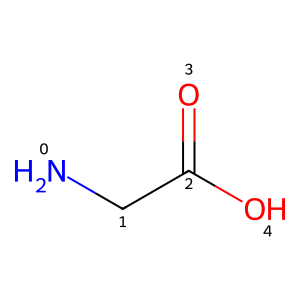

In [12]:
from IPython.display import display

smi = "NCC(=O)O"
mol = MolFromSmiles(smi)
display(draw(mol))

Deprotonate the atom 4 in the glycine (oxygen of carboxylic group)

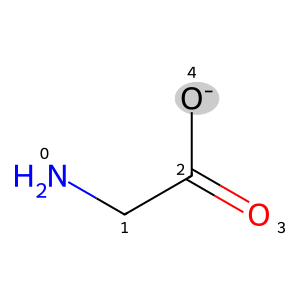

In [13]:
from rdkit.Chem import RemoveHs
mol_deprot = RemoveHs(prot(mol, 4, "a2b"))
smi_deprot = MolToSmiles(mol_deprot)
display(draw(mol_deprot, highlightAtoms=[4]))

Protonate the atom 0 in the glycine (nitrogen of amino group)

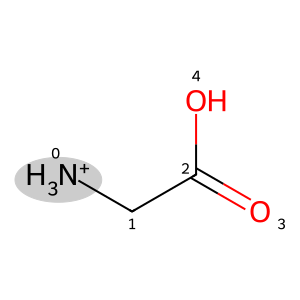

In [14]:
mol_prot = RemoveHs(prot(mol, 0, "b2a"))
smi_prot = MolToSmiles(mol_prot)
display(draw(mol_prot, highlightAtoms=[0]))

Deprotonating the carboxylic acid in the protonated glycine or Protonating the amino group in the deprotonated glycine converges to the zwitter ion form

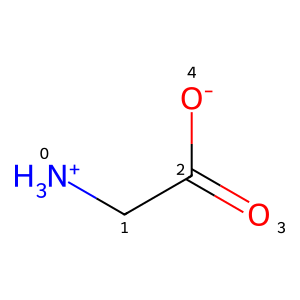

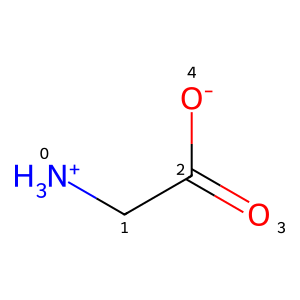

In [15]:
mol_zwitter = RemoveHs(prot(mol_prot, 4, "a2b"))
smi_zwitter = MolToSmiles(mol_zwitter)
display(draw(mol_zwitter))
display(draw(RemoveHs(prot(mol_deprot, 0, "b2a"))))

Micro-p*K*<sub>a</sub> prediction function

In [16]:
import math
from typing import Literal
LN10 = math.log(10)
TRANSLATE_PH = 6.504894871171601

from rdkit.Chem.rdChemReactions import ReactionFromSmarts
from rdkit.Chem.Draw import ReactionToImage

def predict_micro_pKa(smi: str, idx: int, mode: Literal["a2b", "b2a"]):
    mol = MolFromSmiles(smi)
    new_mol = RemoveHs(prot(mol, idx, mode))
    new_smi = MolToSmiles(new_mol)
    if mode == "a2b":
        smi_A = smi
        smi_B = new_smi
    elif mode == "b2a":
        smi_B = smi
        smi_A = new_smi
    DfGm = predictor.predict([smi_A, smi_B])
    pKa = (DfGm[smi_B] - DfGm[smi_A]) / LN10 + TRANSLATE_PH
    pKa_image = ReactionToImage(ReactionFromSmarts(f"{smi_A}>>{smi_B}", useSmiles=True))
    display(pKa_image)
    return pKa

Predict all Micro-p*K*<sub>a</sub> between 4 protonation states of glycine above. Check the consistency of the thermodynamic cycle of two routes of deprotonation through the non-charged form or the zwitterion form. 

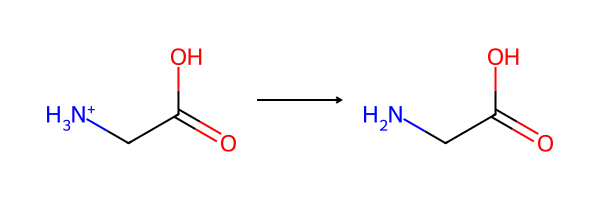

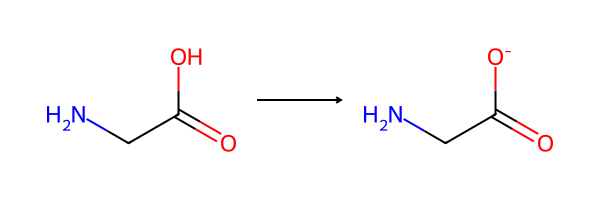

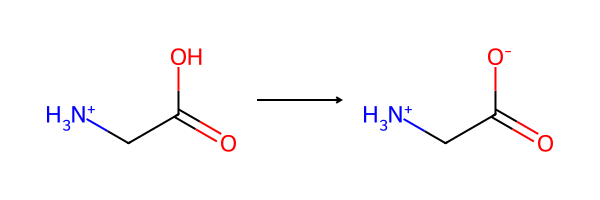

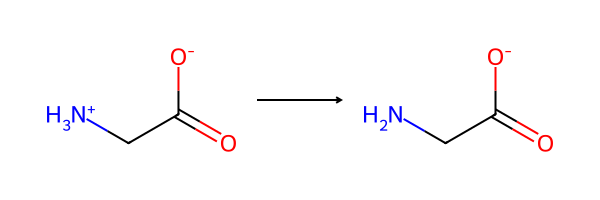

In [17]:
from IPython.display import display_markdown, display_latex

micro_pKa_1 = predict_micro_pKa(smi_prot, 0, "a2b")
display_latex(f"1-H<sub>2</sub>A<sup>+</sup> → 1-HA, pK<sub>a1</sub>: {micro_pKa_1:.2f}", raw=True)
micro_pKa_2 = predict_micro_pKa(smi, 4, "a2b")
display_latex(f"1-HA → 1-A<sup>-</sup>, pK<sub>a2</sub>: {micro_pKa_2:.2f}", raw=True)
micro_pKa_3 = predict_micro_pKa(smi_prot, 4, "a2b")
display_latex(f"1-H<sub>2</sub>A<sup>+</sup> → 2-HA, p*K*<sub>a3</sub>: {micro_pKa_3:.2f}", raw=True)
micro_pKa_4 = predict_micro_pKa(smi_zwitter, 0, "a2b")
display_latex(f"2-HA → 1-A<sup>-</sup>, pK<sub>a4</sub>: {micro_pKa_4:.2f}", raw=True)
display_latex(f"pK<sub>a1</sub> + pK<sub>a2</sub> = {micro_pKa_1:.2f} + {micro_pKa_2:.2f} = {micro_pKa_1 + micro_pKa_2:.2f}", raw=True)
display_latex(f"pK<sub>a3</sub> + pK<sub>a4</sub> = {micro_pKa_3:.2f} + {micro_pKa_4:.2f} = {micro_pKa_3 + micro_pKa_4:.2f}", raw=True)

# Microstate Enumerator

Enumeration function that starts from a single protonation state and ends with the whole macrostate of it and the one after its protonation/deprotonation, given a ionization site template.

In [18]:
from typing import List, Tuple, Union, Callable
from collections import OrderedDict
import pandas as pd
from rdkit.Chem import CanonSmiles, MolFromSmarts


FILTER_PATTERNS = list(map(MolFromSmarts, [
    "[#6X5]",
    "[#7X5]",
    "[#8X4]",
    "[*r]=[*r]=[*r]",
    "[#1]-[*+1]~[*-1]",
    "[#1]-[*+1]=,:[*]-,:[*-1]",
    "[#1]-[*+1]-,:[*]=,:[*-1]",
    "[*+2]",
    "[*-2]",
    "[#1]-[#8+1].[#8-1,#7-1,#6-1]",
    "[#1]-[#7+1,#8+1].[#7-1,#6-1]",
    "[#1]-[#8+1].[#8-1,#6-1]",
    "[#1]-[#7+1].[#8-1]-[C](-[C,#1])(-[C,#1])",
    # "[#6;!$([#6]-,:[*]=,:[*]);!$([#6]-,:[#7,#8,#16])]=[C](-[O,N,S]-[#1])",
    # "[#6]-,=[C](-[O,N,S])(-[O,N,S]-[#1])",
    "[OX1]=[C]-[OH2+1]",
    "[NX1,NX2H1,NX3H2]=[C]-[O]-[H]",
    "[#6-1]=[*]-[*]",
    "[cX2-1]",
    "[N+1](=O)-[O]-[H]"
]))


def sanitize_checker(smi: str, filter_patterns: List[Mol], verbose: bool=False) -> bool:
    """
    Check if a SMILES can be sanitized and does not contain unreasonable chemical structures.

    Params:
    ----
    `smi`: The SMILES to be check.

    `filter_patterns`: Unreasonable chemical structures.

    `verbose`: If True, matched unreasonable chemical structures will be printed.

    Return:
    ----
    If the SMILES should be filtered.
    """
    mol = AddHs(MolFromSmiles(smi))
    for pattern in filter_patterns:
        match = mol.GetSubstructMatches(pattern)
        if match:
            if verbose:
                print(f"pattern {pattern}")
            return False
    try:
        SanitizeMol(mol)
    except:
        print("cannot sanitize")
        return False
    return True


def sanitize_filter(smis: List[str], filter_patterns: List[Mol]=FILTER_PATTERNS) -> List[str]:
    """
    A filter for SMILES can be sanitized and does not contain unreasonable chemical structures.

    Params:
    ----
    `smis`: The list of SMILES.

    `filter_patterns`: Unreasonable chemical structures.

    Return:
    ----
    The list of SMILES filtered.
    """
    def _checker(smi):
        return sanitize_checker(smi, filter_patterns)
    return list(filter(_checker, smis))


def cnt_stereo_atom(smi: str) -> int:
    """
    Count the stereo atoms in a SMILES
    """
    mol = MolFromSmiles(smi)
    return sum([str(atom.GetChiralTag()) != "CHI_UNSPECIFIED" for atom in mol.GetAtoms()])


def stereo_filter(smis: List[str]) -> List[str]:
    """
    A filter against SMILES losing stereochemical information in structure processing.
    """
    filtered_smi_dict = dict()
    for smi in smis:
        nonstereo_smi = CanonSmiles(smi, useChiral=0)
        stereo_cnt = cnt_stereo_atom(smi)
        if nonstereo_smi not in filtered_smi_dict:
            filtered_smi_dict[nonstereo_smi] = (smi, stereo_cnt)
        else:
            if stereo_cnt > filtered_smi_dict[nonstereo_smi][1]:
                filtered_smi_dict[nonstereo_smi] = (smi, stereo_cnt)
    return [value[0] for value in filtered_smi_dict.values()]


def make_filter(filter_param: OrderedDict) -> Callable:
    """
    Make a sequential SMILES filter

    Params:
    ----
    `filter_param`: An `collections.OrderedDict` whose keys are single filter functions and the corresponding values are their parameter dictionary.

    Return:
    ----
    The sequential filter function
    """
    def seq_filter(smis):
        for single_filter, param in filter_param.items():
            smis = single_filter(smis, **param)
        return smis
    return seq_filter


def match_template(template: pd.DataFrame, mol: Mol, verbose: bool=False) -> list:
    '''
    Find protonation site using templates

    Params:
    ----
    `template`: `pandas.Dataframe` with columns of substructure names, SMARTS patterns, protonation indices and acid/base flags

    `mol`: Molecule

    `verbose`: Boolean flag for printing matching results

    Return:
    ----
    A set of matched indices to be (de)protonated
    '''
    mol = AddHs(mol)
    matches = []
    for idx, name, smarts, index, acid_base in template.itertuples():
        pattern = MolFromSmarts(smarts)
        match = mol.GetSubstructMatches(pattern)
        if len(match) == 0:
            continue
        else:
            index = int(index)
            for m in match:
                matches.append(m[index])
                if verbose:
                    print(f"find index {m[index]} in pattern {name} smarts {smarts}")
    return list(set(matches))


def prot_template(template: pd.DataFrame, smi: str, mode: str) -> Tuple[List[int], List[str]]:
    """
    Protonate / Deprotonate a SMILES at every found site in the template

    Params:
    ----
    `template`: `pandas.Dataframe` with columns of substructure names, SMARTS patterns, protonation indices and acid/base flags

    `smi`: The SMILES to be processed

    `mode`: `a2b` means deprotonization, with a hydrogen atom or a heavy atom at `idx`; `b2a` means protonization, with a heavy atom at `idx`
    """
    mol = MolFromSmiles(smi)
    sites = match_template(template, mol)
    smis = []
    for site in sites:
        smis.append(CanonSmiles(MolToSmiles(RemoveHs(prot(mol, site, mode)))))
    return sites, list(set(smis))


def enumerate_template(smi: Union[str, List[str]], template_a2b: pd.DataFrame, template_b2a: pd.DataFrame, mode: str="A", maxiter: int=10, verbose: int=0, filter_patterns: List[Mol]=FILTER_PATTERNS) -> Tuple[List[str], List[str]]:
    """
    Enumerate all the (de)protonation results of one SMILES.

    Params:
    ----
    `smi`: The smiles to be processed.

    `template_a2b`: `pandas.Dataframe` with columns of substructure names, SMARTS patterns, deprotonation indices and acid flags.

    `template_b2a`: `pandas.Dataframe` with columns of substructure names, SMARTS patterns, protonation indices and base flags.

    `mode`: 
        - "a2b": `smi` is an acid to be deprotonated.
        - "b2a": `smi` is a base to be protonated.

    `maxiter`: Max iteration number of template matching and microstate pool growth.

    `verbose`:
        - 0: Silent mode.
        - 1: Print the length of microstate pools in each iteration.
        - 2: Print the content of microstate pools in each iteration.

    `filter_patterns`: Unreasonable chemical structures.

    Return:
    ----
    A microstate pool and B microstate pool after enumeration.
    """
    if isinstance(smi, str):
        smis = [smi]
    else:
        smis = list(smi)

    enum_func = lambda x: [x] # TODO: Tautomerism enumeration

    if mode == "a2b":
        smis_A_pool, smis_B_pool = smis, []
    elif mode == "b2a":
        smis_A_pool, smis_B_pool = [], smis
    filters = make_filter({
        sanitize_filter: {"filter_patterns": filter_patterns},
        stereo_filter: {}
    })
    pool_length_A = -1
    pool_length_B = -1
    i = 0
    while (len(smis_A_pool) != pool_length_A or len(smis_B_pool) != pool_length_B) and i < maxiter:
        pool_length_A, pool_length_B = len(smis_A_pool), len(smis_B_pool)
        if verbose > 0:
            print(f"iter {i}: {pool_length_A} acid, {pool_length_B} base")
        if verbose > 1:
            print(f"iter {i}, acid: {smis_A_pool}, base: {smis_B_pool}")
        if (mode == "a2b" and (i + 1) % 2) or (mode == "b2a" and i % 2):
            smis_A_tmp_pool = []
            for smi in smis_A_pool:
                smis_B_pool += filters(prot_template(template_a2b, smi, "a2b")[1])
                smis_A_tmp_pool += filters([CanonSmiles(MolToSmiles(mol)) for mol in enum_func(MolFromSmiles(smi))])
            smis_A_pool += smis_A_tmp_pool
        elif (mode == "b2a" and (i + 1) % 2) or (mode == "a2b" and i % 2):
            smis_B_tmp_pool = []
            for smi in smis_B_pool:
                smis_A_pool += filters(prot_template(template_b2a, smi, "b2a")[1])
                smis_B_tmp_pool += filters([CanonSmiles(MolToSmiles(mol)) for mol in enum_func(MolFromSmiles(smi))])
            smis_B_pool += smis_B_tmp_pool
        smis_A_pool = filters(smis_A_pool)
        smis_B_pool = filters(smis_B_pool)
        smis_A_pool = list(set(smis_A_pool))
        smis_B_pool = list(set(smis_B_pool))
        i += 1
    if verbose > 0:
            print(f"iter {i}: {pool_length_A} acid, {pool_length_B} base")
    if verbose > 1:
        print(f"iter {i}, acid: {smis_A_pool}, base: {smis_B_pool}")
    smis_A_pool = list(map(CanonSmiles, smis_A_pool))
    smis_B_pool = list(map(CanonSmiles, smis_B_pool))
    return smis_A_pool, smis_B_pool

We define the minimal ionizaton template for our amino acid example, which only includes the ionization of carboxylic acids and amines.

In [19]:
template_a2b = pd.DataFrame([
    {"substructure": "Carboxylic acid", "SMARTS": "[$([#6]=[#8]):0]-[OX2:1]-[H:2]", "Index": 1, "Acid_or_base": "A"},
    {"substructure": "Amine", "SMARTS": "[NX4+1:0]", "Index": 0, "Acid_or_base": "A"}
])
template_b2a = pd.DataFrame([
    {"substructure": "Carboxylic acid", "SMARTS": "[$([#6]=[#8]):0]-[O-1:1]", "Index": 1, "Acid_or_base": "B"},
    {"substructure": "Amine", "SMARTS": "[NX3:0]", "Index": 0, "Acid_or_base": "B"}
])

This is a glutamic acid.

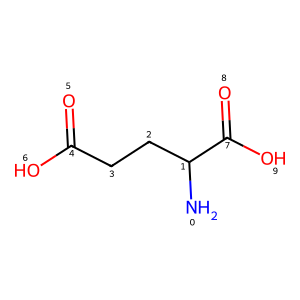

In [20]:
smi_GLU = "NC(CCC(=O)O)C(=O)O"
display(draw(MolFromSmiles(smi_GLU)))

Enumerate the macrostates of the glutamic acid and its deprotonated form.

In [21]:
macrostate_A, macrostate_B = enumerate_template(smi_GLU, template_a2b, template_b2a, mode="a2b")

Drawing a macrostate with microstate indices

In [22]:
from rdkit.Chem.Draw import MolsToGridImage

def draw_macrostate(macrostate: List[str], base_name: str):
    macrostate_mols = list(map(MolFromSmiles, macrostate))
    macrostate_size = len(macrostate_mols)
    legends = [f"{i+1}-{base_name}" for i in range(macrostate_size)]
    display(MolsToGridImage(macrostate_mols, legends=legends, useSVG=True))

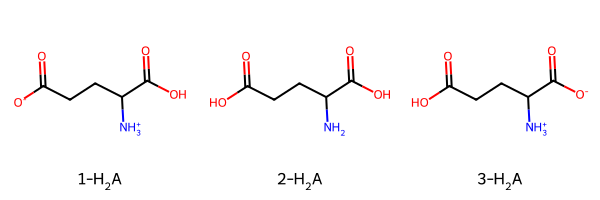

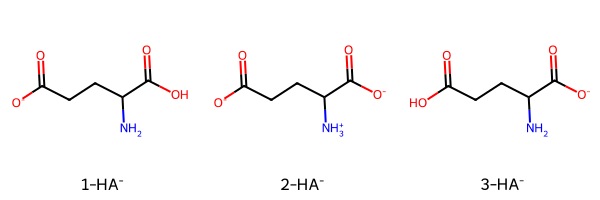

In [23]:
draw_macrostate(macrostate_A, "H<sub>2</sub>A")
draw_macrostate(macrostate_B, "HA<sup>-</sup>")

Continue to generate the fully protonated macrostate and the fully deprotonated one

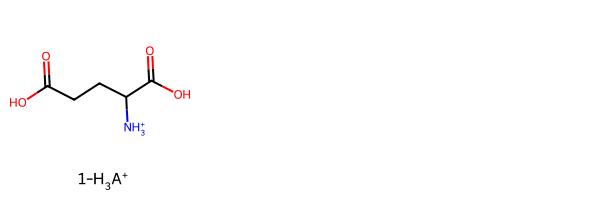

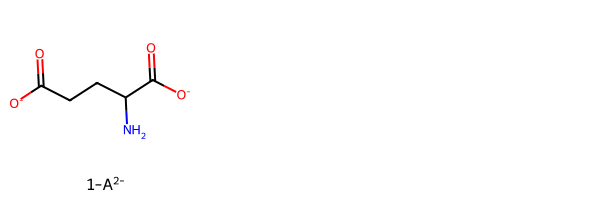

In [24]:
macrostate_AA, _ = enumerate_template(macrostate_A, template_a2b, template_b2a, mode="b2a")
draw_macrostate(macrostate_AA, "H<sub>3</sub>A<sup>+</sup>")
_, macrostate_BB = enumerate_template(macrostate_B, template_a2b, template_b2a, mode="a2b")
draw_macrostate(macrostate_BB, "A<sup>2-</sup>")

# Macro p*K*<sub>a</sub> prediction

Macro-p*K*<sub>a</sub> prediction function

In [25]:
def log_sum_exp(DfGm: List[float]) -> float:
    return math.log10(sum([math.exp(-g) for g in DfGm]))


def predict_macro_pKa(smi: str, template_a2b: pd.DataFrame, template_b2a: pd.DataFrame, mode: Literal["a2b", "b2a"]) -> float:
    macrostate_A, macrostate_B = enumerate_template(smi, template_a2b, template_b2a, mode)
    DfGm_A = predictor.predict(macrostate_A)
    DfGm_B = predictor.predict(macrostate_B)
    draw_macrostate(macrostate_A, "A")
    draw_macrostate(macrostate_B, "B")
    return log_sum_exp(DfGm_A.values()) - log_sum_exp(DfGm_B.values()) + TRANSLATE_PH

Predict all macro-p*K*<sub>a</sub> of the glutamic acid, and show the corresponding acid/basic macrostates.

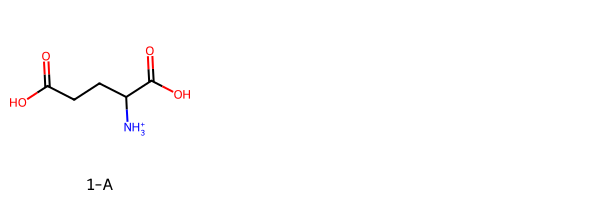

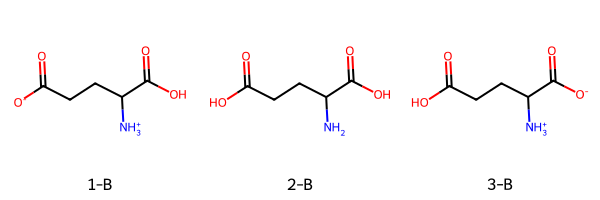

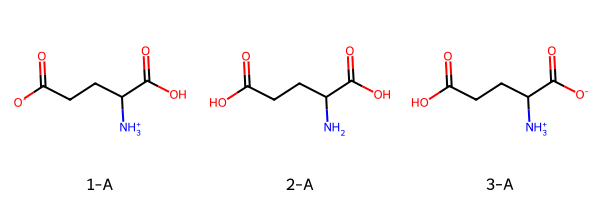

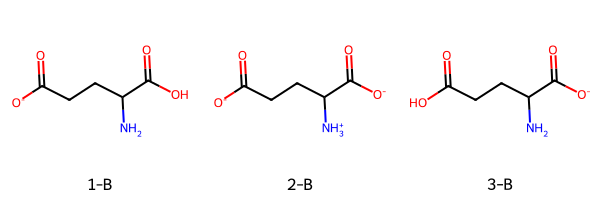

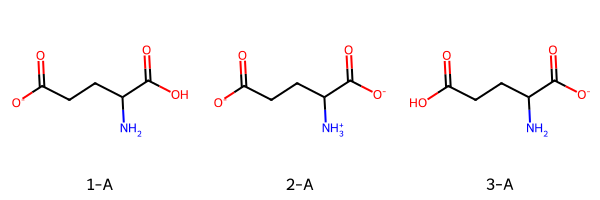

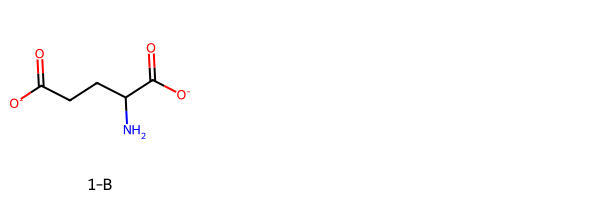

In [26]:
macro_pKa_1 = predict_macro_pKa(smi_GLU, template_a2b, template_b2a, "b2a")
display_latex(f"H<sub>3</sub>A<sup>+</sup> → H<sub>2</sub>A, pK<sub>a1</sub>: {macro_pKa_1:.2f}", raw=True)
macro_pKa_2 = predict_macro_pKa(smi_GLU, template_a2b, template_b2a, "a2b")
display_latex(f"H<sub>2</sub>A → HA<sup>-</sup>, pK<sub>a2</sub>: {macro_pKa_2:.2f}", raw=True)
macro_pKa_3 = predict_macro_pKa(macrostate_B, template_a2b, template_b2a, "a2b")
display_latex(f"HA<sup>-</sup> → A<sup>2-</sup>, pK<sub>a2</sub>: {macro_pKa_3:.2f}", raw=True)

# Distribution fraction prediction

Standardized microstate name calculation function.

In [27]:
def calc_base_name(neutral_base_name: str, target_charge: int) -> str:
    if neutral_base_name.startswith("H"):
        if neutral_base_name[1:].startswith("<sub>"):
            num_H_end = neutral_base_name.find("</sub>", 6)
            num_H = int(neutral_base_name[6:num_H_end])
        else:
            num_H_end = 1
            num_H = 1
    else:
        num_H_end = 0
        num_H = 0
    target_num_H = num_H + target_charge
    assert target_num_H >= 0
    target_base_name = ""
    if target_num_H == 1:
        target_base_name += "H"
    elif target_num_H > 1:
        target_base_name += f"H<sub>{target_num_H}</sub>"
    target_base_name += "A"
    if target_charge < -1:
        target_base_name += f"<sup>{-target_charge}-</sup>"
    elif target_charge == -1:
        target_base_name += f"<sup>-</sup>"
    elif target_charge == 1:
        target_base_name += f"<sup>+</sup>"
    elif target_charge > 1:
        target_base_name += f"<sup>{target_charge}+</sup>"
    return target_base_name

Enumeration function that starts with one microstate and ends with the whole protonation ensemble, given the ionization templates.

In [66]:
from rdkit.Chem import GetFormalCharge
from typing import Dict


def get_ensemble(smi: str, template_a2b: pd.DataFrame, template_b2a: pd.DataFrame, maxiter: int=10) -> Dict[int, List[str]]:
    ensemble = dict()
    q0 = GetFormalCharge(MolFromSmiles(smi))
    ensemble[q0] = [smi]

    smis_0 = [smi]

    smis_0, smis_b1 = enumerate_template(smis_0, template_a2b, template_b2a, maxiter=maxiter, mode="a2b")
    if smis_b1:
        ensemble[q0 - 1] = smis_b1
    q = q0 - 2
    while True:
        if q + 1 in ensemble:
            _, smis_b = enumerate_template(ensemble[q + 1], template_a2b, template_b2a, maxiter=maxiter, mode="a2b")
            print(f"  生成了 {len(smis_b)} 个新结构") #fzn
            if smis_b:
                ensemble[q] = smis_b
            else:
                print("  没有新结构生成，退出循环") #fzn
                break
        else: #fzn
            print(f"  q+1 ({q+1}) 不在 ensemble 中，退出循环") #fzn
            break #fzn
        q -= 1

    smis_a1, smis_0 = enumerate_template(smis_0, template_a2b, template_b2a, maxiter=maxiter, mode="b2a")
    if smis_a1:
        ensemble[q0 + 1] = smis_a1
    q = q0 + 2
    while True:
        if q - 1 in ensemble:
            smis_a, _ = enumerate_template(ensemble[q - 1], template_a2b, template_b2a, maxiter=maxiter, mode="b2a")
            print(f"  生成了 {len(smis_a)} 个新结构") #fzn
            if smis_a:
                ensemble[q] = smis_a
            else:
                print("  没有新结构生成，退出循环") #fzn
                break
        else: #fzn
            print(f"  q+1 ({q+1}) 不在 ensemble 中，退出循环") #fzn
            break #fzn
        q += 1
    
    ensemble[q0] = smis_0
    return ensemble


def get_neutral_base_name(ensemble: Dict[int, List[str]]) -> str:
    q_list = sorted(ensemble.keys())
    min_q = -int(min(q_list))
    return "A" if min_q == 0 else f"H<sub>{min_q}</sub>A"

def draw_ensemble(ensemble: Dict[int, List[str]]) -> None:
    q_list = sorted(ensemble.keys())
    neutral_base_name = get_neutral_base_name(ensemble)
    for q in q_list:
        draw_macrostate(ensemble[q], calc_base_name(neutral_base_name, q))

The protonation ensemble of a glutamic acid when the ionization of its carboxylic group and amino group is considered.

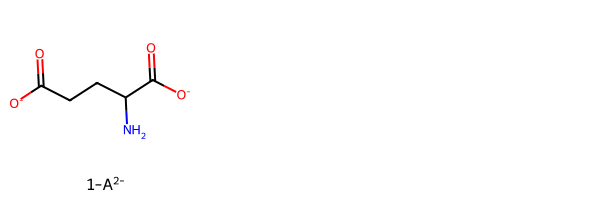

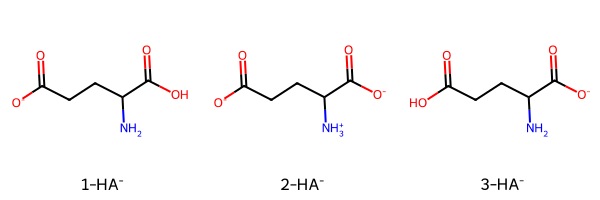

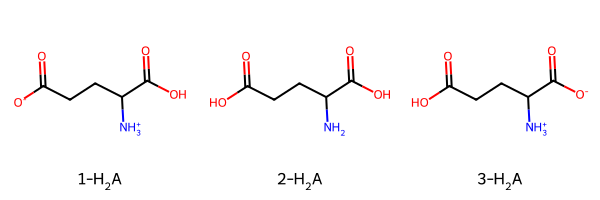

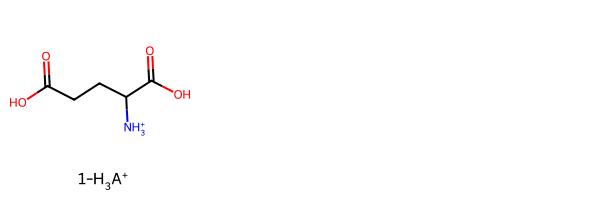

In [29]:
GLU_ensemble = get_ensemble(smi_GLU, template_a2b, template_b2a)
draw_ensemble(GLU_ensemble)

Prediction function for fractions of microstates in the protonation ensemble at given pH.

In [30]:
from collections import defaultdict
import pylab as pl


def predict_ensemble_free_energy(smi: str, template_a2b: pd.DataFrame, template_b2a: pd.DataFrame) -> Dict[int, Tuple[str, float]]:
    ensemble = get_ensemble(smi, template_a2b, template_b2a)
    ensemble_free_energy = dict()
    for q, macrostate in ensemble.items():
        prediction = predictor.predict(macrostate)
        ensemble_free_energy[q] = [(microstate, prediction[microstate]) for microstate in macrostate]
    return ensemble_free_energy


def calc_distribution(ensemble_free_energy: Dict[int, Dict[str, float]], pH: float) -> Dict[int, Dict[str, float]]:
    ensemble_boltzmann_factor = defaultdict(list)
    partition_function = 0
    for q, macrostate_free_energy in ensemble_free_energy.items():
        for microstate, DfGm in macrostate_free_energy:
            boltzmann_factor = math.exp(-DfGm - q * LN10 * (pH - TRANSLATE_PH))
            partition_function += boltzmann_factor
            ensemble_boltzmann_factor[q].append((microstate, boltzmann_factor))
    return {
        q: [(microstate, boltzmann_factor / partition_function) for microstate, boltzmann_factor in macrostate_boltzmann_factor] 
        for q, macrostate_boltzmann_factor in ensemble_boltzmann_factor.items()
    }


def draw_distribution_pH(ensemble_free_energy: Dict[int, Dict[str, float]]) -> None:
    pHs = np.linspace(0, 14, 1000)
    fractions = defaultdict(list)
    name_mapping = dict()
    ensemble = defaultdict(list)
    neutral_base_name = get_neutral_base_name(ensemble_free_energy)
    for q, macrostate in ensemble_free_energy.items():
        for i, (microstate, _) in enumerate(macrostate):
            name_mapping[microstate] = f"{i+1}-{calc_base_name(neutral_base_name, q)}"
            ensemble[q].append(microstate)
    for pH in pHs:
        distribution = calc_distribution(ensemble_free_energy, pH)
        for q, macrostate_fraction in distribution.items():
            for microstate, fraction in macrostate_fraction:
                fractions[name_mapping[microstate]].append(fraction)
    pl.figure(figsize=(14, 3), dpi=200)
    for base_name, fraction_curve in fractions.items():
        pl.plot(pHs, fraction_curve, label=base_name.replace("<sub>", "$_{").replace("</sub>", "}$").replace("<sup>", "$^{").replace("</sup>", "}$"))
    draw_ensemble(ensemble)
    pl.xlabel("pH")
    pl.ylabel("fraction")
    pl.legend()
    pl.show()
    

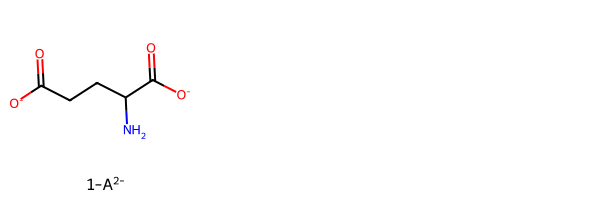

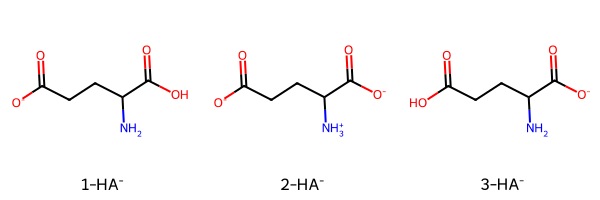

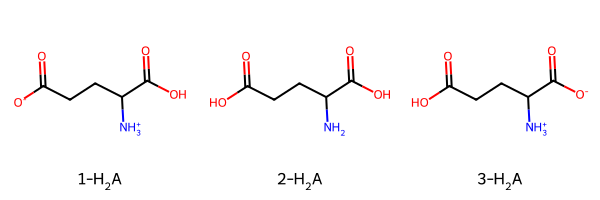

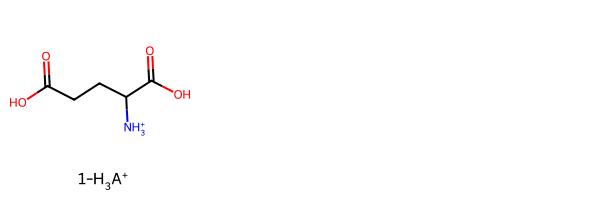

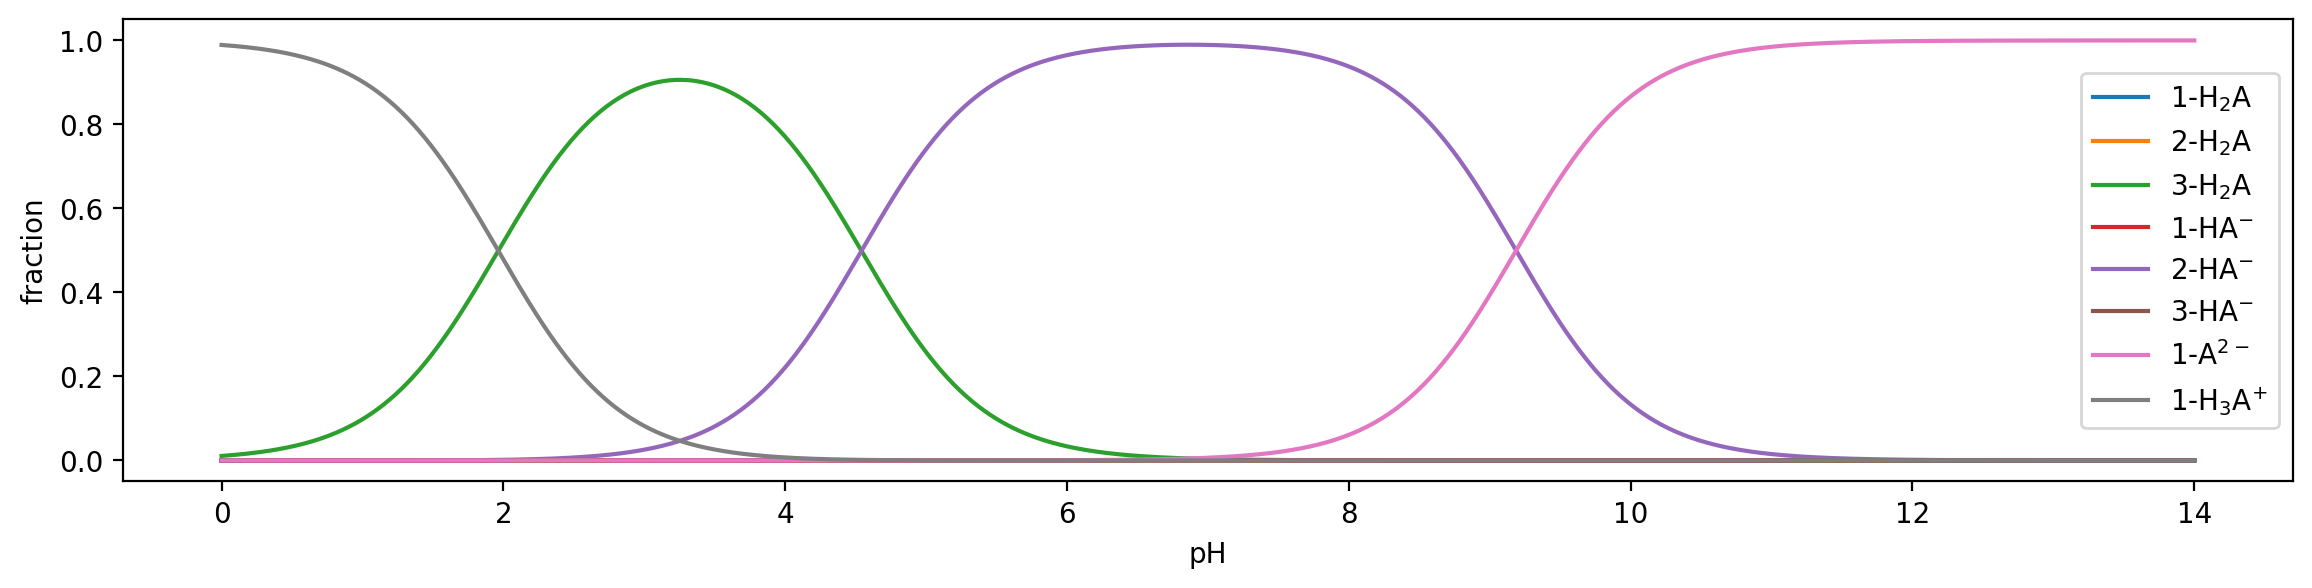

In [31]:
GLU_ensemble_free_energy = predict_ensemble_free_energy(smi_GLU, template_a2b, template_b2a)
draw_distribution_pH(GLU_ensemble_free_energy)

# Play with more complete templates

Template reading function from a csv template file. 

In [32]:
def read_template(template_file: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Read a protonation template.

    Params:
    ----
    `template_file`: path of `.csv`-like template, with columns of substructure names, SMARTS patterns, protonation indices and acid/base flags

    Return:
    ----
    `template_a2b`, `template_b2a`: acid to base and base to acid templates
    '''
    template = pd.read_csv(template_file, sep="\t")
    template_a2b = template[template.Acid_or_base == "A"]
    template_b2a = template[template.Acid_or_base == "B"]
    return template_a2b, template_b2a

More complete ionization templates are provided in the dataset. The "simple_smarts_pattern.tsv" collects common ionization pattern in medicinal chemistry and is suitable for general purpose. 

The more radical "smarts_pattern.tsv" covers all ionization pattern in our training set and was used in the original paper for macro-p*K*<sub>a</sub> prediction evaluation. **Warning: very unreasonable protonation states in the aqueous solution may be enumerated with this template and affect distribution fraction prediction drastically in some cases!**

In [33]:
template_a2b_simple, template_b2a_simple = read_template("/bohr/uni-pka-ckpt-ancf/v2/simple_smarts_pattern.tsv")
template_a2b_full, template_b2a_full = read_template("/bohr/uni-pka-ckpt-ancf/v2/smarts_pattern.tsv")

In [34]:
template_a2b_simple

,Substructure,SMARTS,Index,Acid_or_base
0,Sulfate monoether,[SX4:0](=[O:1])(=[O:2])(-[O:3])-[OX2:4]-[H:5],4,A
2,Sulfonic acid,"[SX4:0](=[O:1])(=[O:2])(-[#6,#7:3])-[OX2:4]-[H:5]",4,A
4,Sulfinic acid,"[SX3:0](=[O:1])(-[#6,#7:2])-[OX2:3]-[H:4]",3,A
6,Seleninic acid,"[SeX3:0](=[O:1])(-[#6,#7:2])-[OX2:3]-[H:4]",3,A
8,Selenenic acid,[SeX2:0]-[OX2:1]-[H:2],1,A
10,Arsonic acid,"[AsX4:0](=[O:1])(-[#6,#7:2])-[OX2:3]-[H:4]",3,A
12,Thiosulfuric acid,[S:0]~[SX4:1](~[O:2])(~[O:3])-[O:4]-[H:5],4,A
14,Phosph(o/i)nic acid,"[PX4:0](=[O:1])(-[OX2:2]-[H:5])(-[#1,#6,#7,#8:...",2,A
16,Phosphate (mono/di)ether,[PX4:0](=[O:1])(-[O:2])(-[O:3])-[OX2:4]-[H:5],4,A
18,Carboxyl acid,"[$([#6]=[#8,#7]),$(C#N):0]-[OX2:1]-[H:2]",1,A


In [35]:
template_a2b_full

,Substructure,SMARTS,Index,Acid_or_base
0,Sulfate monoether,[SX4:0](=[O:1])(=[O:2])(-[O:3])-[OX2:4]-[H:5],4,A
2,Sulfonic acid,"[SX4:0](=[O:1])(=[O:2])(-[#6,#7:3])-[OX2:4]-[H:5]",4,A
4,Sulfinic acid,"[SX3:0](=[O:1])(-[#6,#7:2])-[OX2:3]-[H:4]",3,A
6,Seleninic acid,"[SeX3:0](=[O:1])(-[#6,#7:2])-[OX2:3]-[H:4]",3,A
8,Selenenic acid,[SeX2:0]-[OX2:1]-[H:2],1,A
10,Arsonic acid,"[AsX4:0](=[O:1])(-[#6,#7:2])-[OX2:3]-[H:4]",3,A
12,Thiosulfuric acid,[S:0]~[SX4:1](~[O:2])(~[O:3])-[O:4]-[H:5],4,A
14,Phosph(o/i)nic acid,"[PX4:0](=[O:1])(-[OX2:2]-[H:5])(-[#1,#6,#7,#8:...",2,A
16,Phosphate (mono/di)ether,[PX4:0](=[O:1])(-[O:2])(-[O:3])-[OX2:4]-[H:5],4,A
18,Carboxyl acid,"[$([#6]=[#8,#7]),$(C#N):0]-[OX2:1]-[H:2]",1,A


Here we try out the drug molecule Amoxicillin.

  q+1 (-1) 不在 ensemble 中，退出循环
  生成了 1 个新结构
  生成了 0 个新结构
  没有新结构生成，退出循环


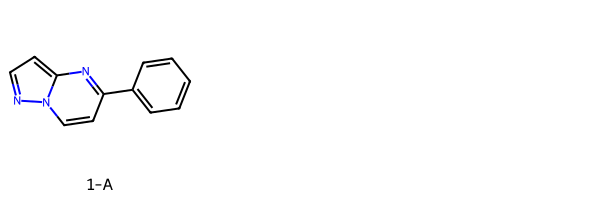

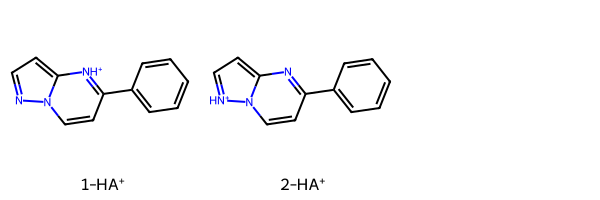

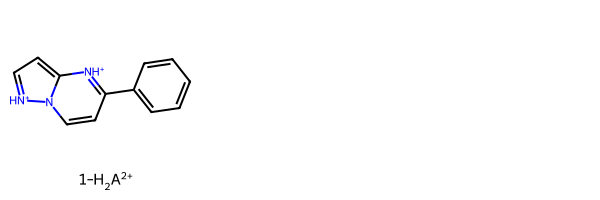

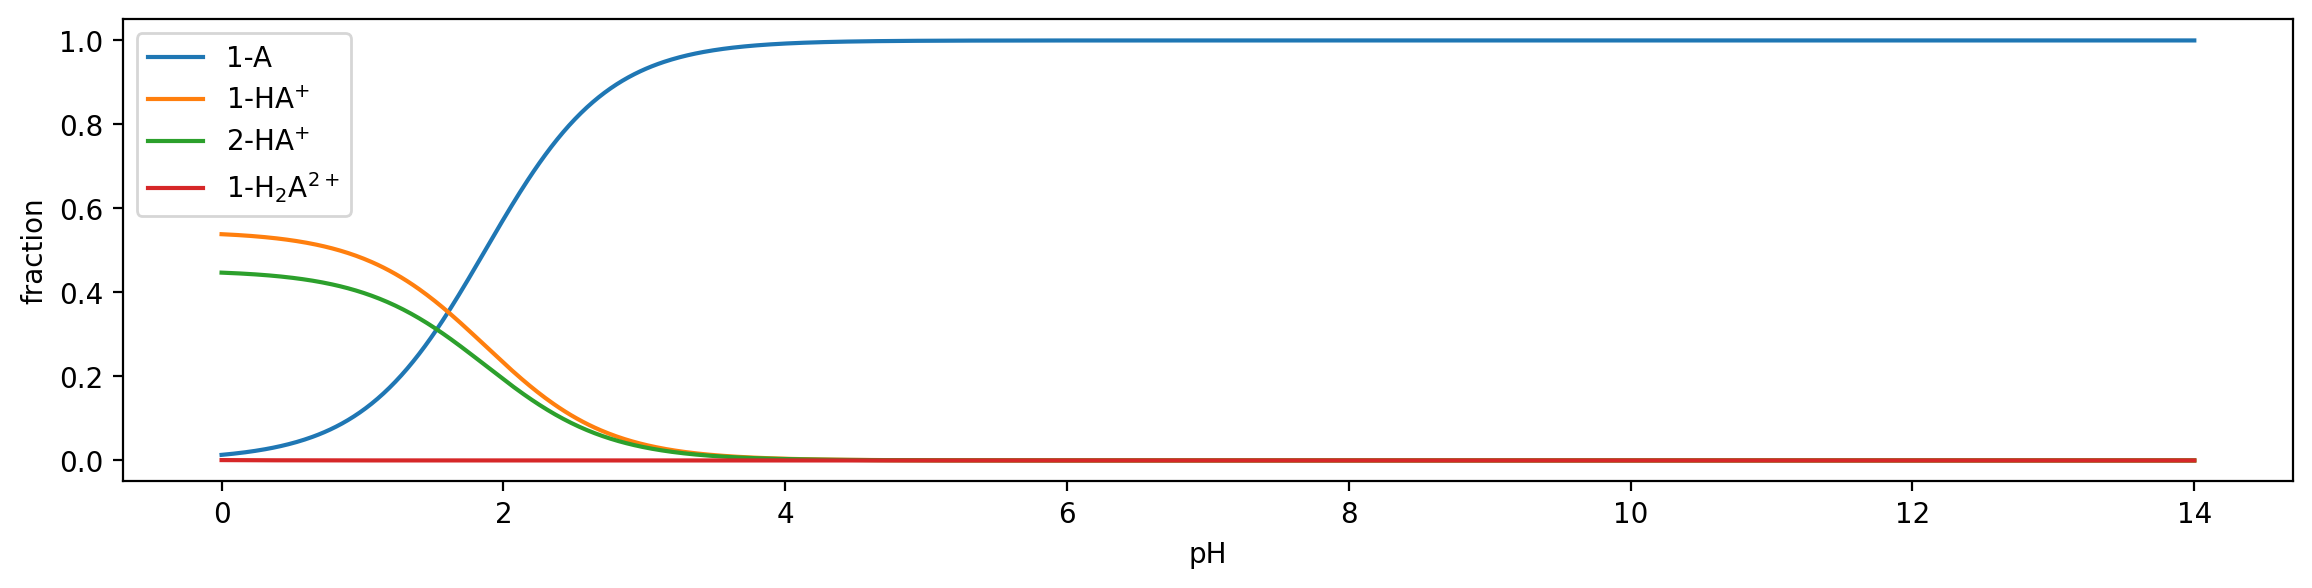

In [68]:
#smi_drug = "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CC=C(C=C3)O)N)C(=O)O)C"
smi_drug = "c1cnn(c12)ccc(n2)-c3ccccc3" #c1nc(C#N)nc(c12)n(cn2)C3CCN(CC3)Cc4ccc(cc4)-n(c(n5)-c6c(N)nccc6)c(c57)nc(cc7)-c8ccccc8
drug_ensemble_free_energy = predict_ensemble_free_energy(smi_drug, template_a2b_simple, template_b2a_simple)
draw_distribution_pH(drug_ensemble_free_energy)

In [37]:
def predict_macro_pKa_from_macrostate(macrostate_A, macrostate_B, A_name, B_name) -> float:
    DfGm_A = predictor.predict(macrostate_A)
    DfGm_B = predictor.predict(macrostate_B)
    draw_macrostate(macrostate_A, A_name)
    draw_macrostate(macrostate_B, B_name)
    return log_sum_exp(DfGm_A.values()) - log_sum_exp(DfGm_B.values()) + TRANSLATE_PH

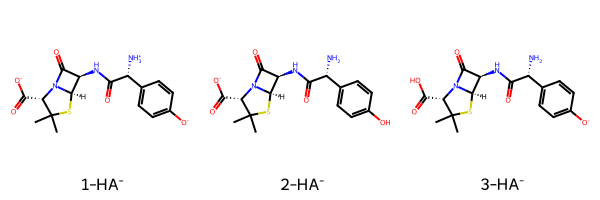

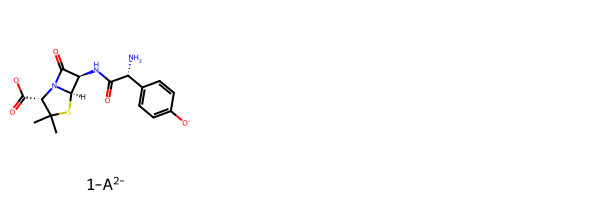

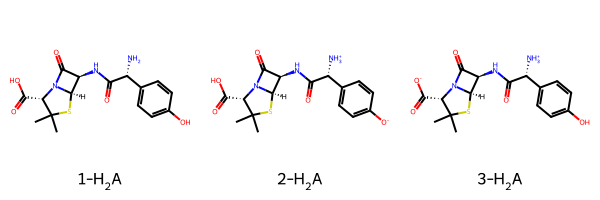

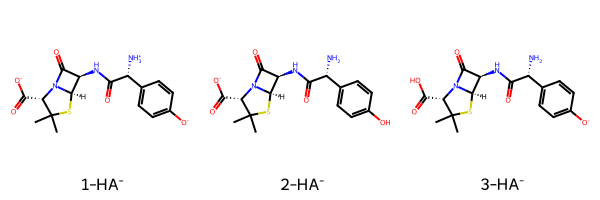

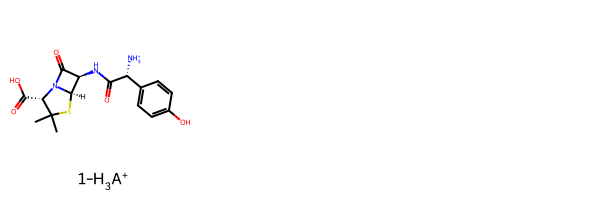

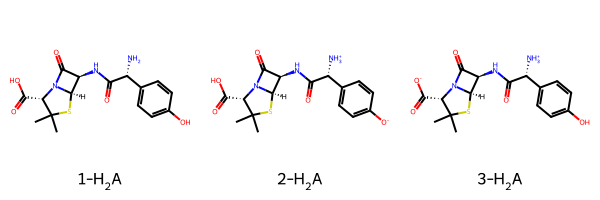

In [38]:
drug_ensemble = get_ensemble(smi_drug, template_a2b_simple, template_b2a_simple)
q_min = min(drug_ensemble.keys())
q_max = max(drug_ensemble.keys())
neutral_base_name = get_neutral_base_name(drug_ensemble)

for i, q in enumerate(range(q_min, q_max)):
    B_name = calc_base_name(neutral_base_name, q)
    A_name = calc_base_name(neutral_base_name, q + 1)
    macro_pKa = predict_macro_pKa_from_macrostate(drug_ensemble[q+1], drug_ensemble[q], A_name, B_name)
    display_latex(f"{A_name} →{B_name}, pK<sub>a{i}</sub>: {macro_pKa:.2f}", raw=True)

A very radical enumeration!

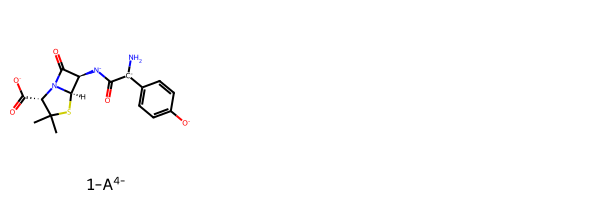

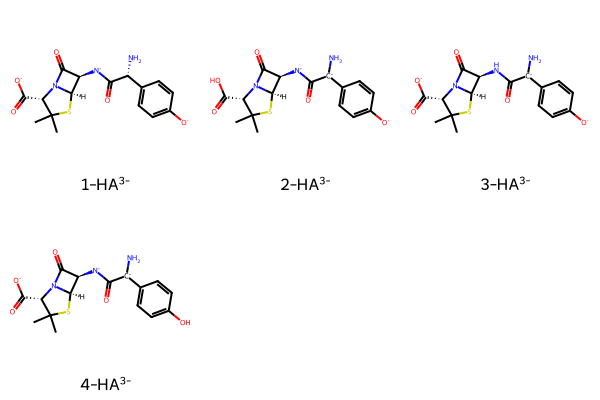

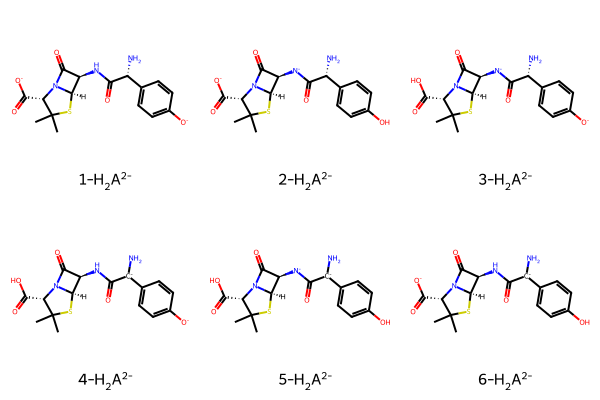

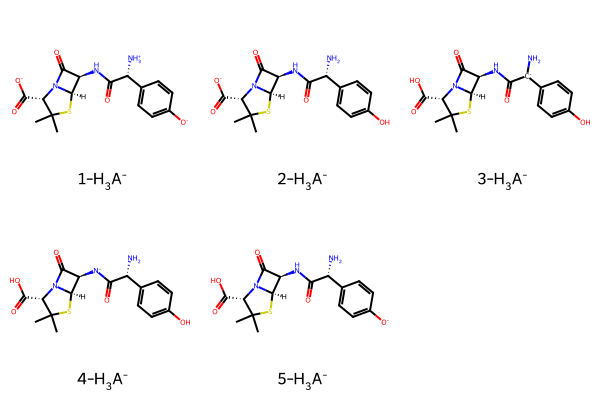

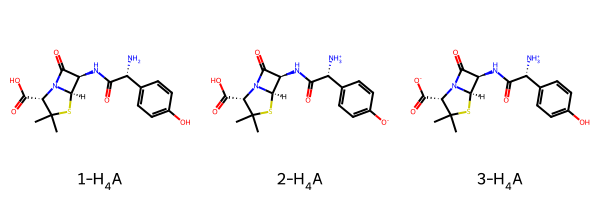

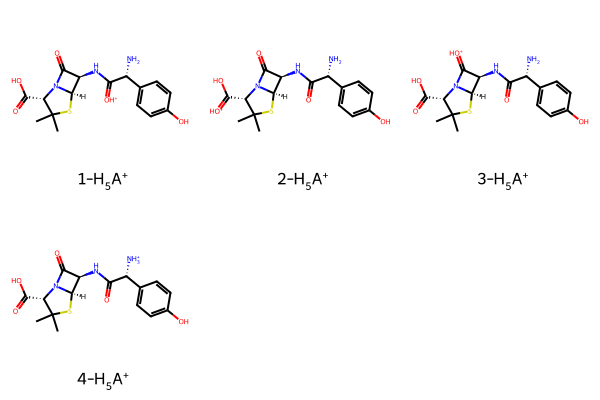

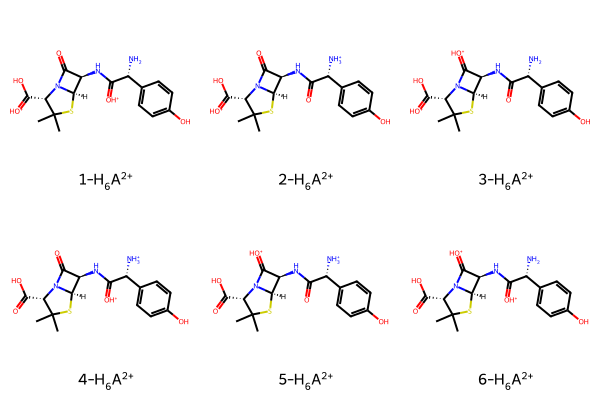

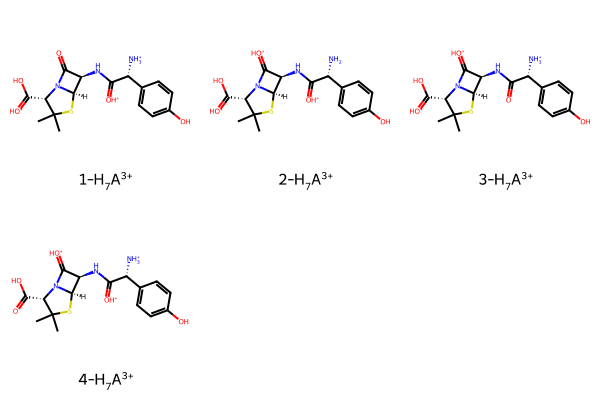

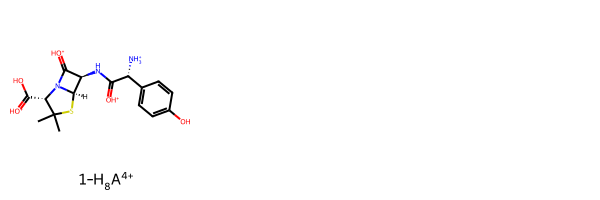

In [39]:
drug_ensemble = get_ensemble(smi_drug, template_a2b_full, template_b2a_full)
draw_ensemble(drug_ensemble)